## 0 - Librairies

In [11]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import numpy as np
from numpy import mean, std

import pandas as pd

from dateutil.relativedelta import relativedelta
#choose kernel (keras-env) when run on Macbook Pro 
import keras
from keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T

from datetime import datetime, timedelta
import calendar
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import toml
import h5py
from utils import *
import joblib
from scipy.fft import irfft, rfft, rfftfreq
from pathlib import Path

from scipy.signal import welch
import seaborn as sns

## 1 - Config

In [12]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = config['data']['t1']
        t2 = config['data']['t2']
        sat = 'mms4'
        density_threshold = config['data']['density_threshold']
        name = "rep_no_thresh_XL"
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

        Path(f"{saved_models_path}/{name}").mkdir(parents=True, exist_ok=True)
        with open(f"{saved_models_path}/{name}/model_config.toml",'w') as fsave:
            toml.dump(config,fsave)

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")
print(f"OHM={OHM}")
print(f"density_threshold={density_threshold}")

Using cuda device
OHM=True
density_threshold=0


In [13]:
file = h5py.File(f'{data_path}','r')
bursts = list(file[f"{sat}"].keys())
file.close()
bursts = pd.DataFrame([datetime.strptime(burst, f'%Y_%m_%dT%H_%M_%S') for burst in bursts])


In [14]:
### R2
print('Bilinear + Ohm')
print(f'{np.sqrt((np.array([0.8198,0.6538,0.5865])**2).mean()):.2}')
print('Bilinear')
print(f'{np.sqrt((np.array([0.6042,0.3107,0.2132])**2).mean()):.2}')
print('Liinear + Ohm')
print(f'{np.sqrt((np.array([0.8429,0.7048,0.6116])**2).mean()):.2}')
print('Liinear')
print(f'{np.sqrt((np.array([0.7955,0.6455,0.5603])**2).mean()):.2}')
### Runtime
print('Bilinear + Ohm')
print(f'{1*60*60+54*60+33} s')
print('Bilinear')
print(f'{1*60*60+54*60+3} s')
print('Liinear + Ohm')
print(f'{0*60*60+35*60+26} s')
print('Liinear')
print(f'{0*60*60+34*60+58} s')
### MSE
print('Bilinear + Ohm')
print(f'{np.sqrt((np.array([2.107,1.784,1.412])**2).mean()):.3} mV/m')
print('Bilinear')
print(f'{np.sqrt((np.array([4.392,3.537,2.284])**2).mean()):.3} mV/m')
print('Liinear + Ohm')
print(f'{np.sqrt((np.array([1.884,1.531,1.366])**2).mean()):.3} mV/m')
print('Liinear')
print(f'{np.sqrt((np.array([2.361,1.795,1.515])**2).mean()):.3} mV/m')

Bilinear + Ohm
0.69
Bilinear
0.41
Liinear + Ohm
0.73
Liinear
0.67
Bilinear + Ohm
6873 s
Bilinear
6843 s
Liinear + Ohm
2126 s
Liinear
2098 s
Bilinear + Ohm
1.79 mV/m
Bilinear
3.51 mV/m
Liinear + Ohm
1.61 mV/m
Liinear
1.92 mV/m


## 2 - Data Loading

In [15]:
dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)

train_data, val_data, test_data = random_split(dataset, [0.8, 0.1, 0.1],generator=torch.Generator().manual_seed(seed))

batch_size = int(2**(np.round(np.log2(0.25*len(train_data)/100))))
print(f"Batch size of ~0.25% of data (rounded to closest power of 2) : {batch_size}")

Batch size of ~0.25% of data (rounded to closest power of 2) : 32768


In [16]:
if sat == 'mms1':
    pass
    #scale = Standard_Scaler(train_data)
    #torch.save(scale,f'{saved_models_path}/{name}/scale.keras')
if sat != 'mms1':
    scale = torch.load(f'{saved_models_path}/{name}/scale.keras')
X_train, y_train = scale.transform(dataset=train_data)
X_val  , y_val   = scale.transform(dataset=val_data)
X_test , y_test  = scale.transform(dataset=test_data)

scale.to(device)
X_train, y_train = X_train.to(device) , y_train.to(device)

print(device)

cuda


In [17]:
df = dataset.to_dataframe()
df_train, df_val, df_test = train_data.dataset.to_dataframe(), val_data.dataset.to_dataframe(), test_data.dataset.to_dataframe()

In [18]:
'''
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(df_train.index,df_train['ex'],s=0.5, rasterized=True, color='green', label='train',alpha=0.33)
ax.scatter(df_val.index,df_val['ex'],s=0.5, rasterized=True, color='blue', label='validation',alpha=0.33)
ax.scatter(df_test.index,df_test['ex'],s=0.5, rasterized=True, color='orange', label='test',alpha=0.33)
plt.xticks(rotation=45)
plt.legend()
'''

"\nfig, ax = plt.subplots(1,1, figsize=(12,8))\n\nax.scatter(df_train.index,df_train['ex'],s=0.5, rasterized=True, color='green', label='train',alpha=0.33)\nax.scatter(df_val.index,df_val['ex'],s=0.5, rasterized=True, color='blue', label='validation',alpha=0.33)\nax.scatter(df_test.index,df_test['ex'],s=0.5, rasterized=True, color='orange', label='test',alpha=0.33)\nplt.xticks(rotation=45)\nplt.legend()\n"

In [19]:
'''def f(X,mid):
    Y = mid + (X - X.mean()) / (X.max() - X.min())
    return Y
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.25)

#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label='train',color='green',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label='validation',color='blue',alpha=0.5)
#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label='test',color='orange',alpha=0.5)

mids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2

ax.axhline(mids[0],color='black',linestyle='--')
ax.axhline(mids[1],color='black',linestyle='--')
ax.axhline(mids[2],color='black',linestyle='--')
ax.plot(df.index.values,1*f(df['ex'],mids[-1]),label='ex')
ax.plot(df.index.values,1*f(df['ey'],mids[-2]),label='ey')
ax.plot(df.index.values,1*f(df['ez'],mids[-3]),label='ez')

ax.set_yticks(mids,[f'{df[e].mean():.2f}' for e in ['ex','ey','ez']])
ax.set_ylim(0,1)
fig.legend()

fig.subplots_adjust(top=0.82)
fig.subplots_adjust(right=1.15)
fig.suptitle("Data partitioning", fontsize=20)

plt.show()'''

'def f(X,mid):\n    Y = mid + (X - X.mean()) / (X.max() - X.min())\n    return Y\nfig, ax = plt.subplots(1, 1, figsize=(12, 8))\nplt.subplots_adjust(hspace=0.25)\n\n#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_train_beg],xmax=df.index[id_train_end],label=\'train\',color=\'green\',alpha=0.5)\n#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_val_beg],xmax=df.index[id_val_end],label=\'validation\',color=\'blue\',alpha=0.5)\n#ax.axvspan(ymin=0,ymax=1, xmin=df.index[id_test_beg],xmax=df.index[id_test_end],label=\'test\',color=\'orange\',alpha=0.5)\n\nmids = 1*(np.linspace(0,1,4)[1:]+np.linspace(0,1,4)[:-1])/2\n\nax.axhline(mids[0],color=\'black\',linestyle=\'--\')\nax.axhline(mids[1],color=\'black\',linestyle=\'--\')\nax.axhline(mids[2],color=\'black\',linestyle=\'--\')\nax.plot(df.index.values,1*f(df[\'ex\'],mids[-1]),label=\'ex\')\nax.plot(df.index.values,1*f(df[\'ey\'],mids[-2]),label=\'ey\')\nax.plot(df.index.values,1*f(df[\'ez\'],mids[-3]),label=\'ez\')\n\nax.set_yticks(mids,[f\'{df[e].mean(

In [20]:
df_theo = E_mhd(df_test)+E_mhd(df_test)

## 3 - Model loading and prediction

In [21]:
def first_dnn(input_size,output_size,scale,device):
    model = keras.Sequential([
        layers.Dense(input_size, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(output_size)
    ])
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(0.0001),metrics=[
                    MaxError(scaler=scale,device=device),
                    MSE(scaler=scale,device=device),
                    keras.metrics.R2Score(
                    class_aggregation=None, num_regressors=0, name="r2_score", dtype=None),
                    PCC()])

    return model

In [22]:
model = first_dnn(np.shape(X_train)[1]-3,3,scale,device)
test_predict = model.predict(X_test,batch_size) 
#Didn't found a way to load model with sizes correctly initialized, so I run a quick evaluate to fixe the output, load the weights then reload it.
model.load_weights(f'{saved_models_path}/{name}/_weights.best.keras')
test_predict = model.predict(X_test,batch_size)
model.summary()

358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
  7/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step

/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,832 (8.08 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - MSE: 2.3664 - PCC: 0.8501 - loss: 0.2224 - max_error: 18.5896 - r2_score: 0.8362
{'MSE': tensor([0.3022, 0.2217, 0.0706], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8780, 0.9089, 0.9222]), 'loss': 0.19738708436489105, 'max_error': tensor([1.7987, 1.5210, 0.8128], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8679, 0.8458, 0.7047], device='cuda:0')}


In [24]:
output_targets = ['ex','ey','ez']

In [26]:
if False: #can be long (~9min) to run and it usefull for checking raw data
    fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
    plt.subplots_adjust(hspace=0.2)


    target_labels = output_targets

    for i in range(y_test.shape[1]):
        ax[i].scatter(df_test.index,y_test[:,i],s=1, rasterized=True, label=target_labels[i],alpha=0.8)
        ax[i].scatter(df_test.index,test_predict[:,i],s=1, rasterized=True, label='Pred {}'.format(target_labels[i]),alpha=0.8)
        #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
        #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
        #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
        ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
        text = str('Pcc = {:.3}'.format(metrics['PCC'][i])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][i]))
        ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
        
    for i in range(y_test.shape[1]-1):
        plt.setp(ax[i].get_xticklabels(), visible=False)

    fig = plt.gcf()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"Comparison between normalized observations and predictions OHM={OHM} on {sat}", fontsize=14)

    plt.show()

In [27]:
if False: #can be long (~9min) to run and it usefull for checking raw data
    fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8),facecolor='white')
    plt.subplots_adjust(hspace=0.2)
    #plt.style.use('ggplot')

    target_labels = output_targets

    for i in range(y_test.shape[1]):
        ax[i].scatter(df_test.index, y_test[:,i]-test_predict[:,i],s=1,rasterized=True, label=target_labels[i],alpha=0.8)
        #ax[i].plot(d_theo_scale[test_ind_begin:test_ind_end,i], label='Theo {}'.format(target_labels[i]),alpha=0.8)
        #ax[i].plot(d_mhd_scale[test_ind_begin:test_ind_end,i], label='MHD {}'.format(target_labels[i]),alpha=0.8)
        #ax[i].plot(d_hall_scale[test_ind_begin:test_ind_end,i], label='Hall {}'.format(target_labels[i]),alpha=0.8)
        ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
        text = str('Pcc = {:.3}'.format(metrics['PCC'][i])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][i]))
        ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
        
    for i in range(y_test.shape[1]-1):
        plt.setp(ax[i].get_xticklabels(), visible=False)

    fig = plt.gcf()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"Difference between normalized observations and predictions OHM={OHM}", fontsize=14)

    plt.show()

In [28]:
# test
scale.to('cpu')
_, predict = scale.untransform(X_test,torch.Tensor(test_predict))

In [29]:
predict = torch.concatenate(scale.untransform(X_test,torch.Tensor(test_predict)),axis=1)

In [30]:
# test 
df_predict = pd.DataFrame(predict)
df_predict.columns = df_test.columns
df_predict['time'] = df_test.index
df_predict = df_predict.set_index(['time'])
df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,ex,ey,ez
time,,,,,,,,,,,,,,,,,,,
2015-09-07 13:11:04.012,8.611988,2.315907,26.088659,9.887346e-09,-1.292836e-09,-1.338598e-08,-54.921829,-15.859553,18.938184,0.797340,0.457614,-1.595932,-0.009388,-0.021352,-2.921594,0.266400,-0.172491,-1.819930,0.268014
2015-09-07 13:11:04.042,8.608479,2.305379,26.047498,3.244311e-09,-2.555208e-08,1.000641e-08,-54.891027,-15.754284,18.833852,0.863801,0.453779,-1.591905,-0.009076,-4.975832,0.011805,1.643426,-0.684929,-1.447738,0.435024
2015-09-07 13:11:04.072,8.593844,2.308444,26.044911,9.349975e-09,-7.071399e-09,-2.148178e-08,-54.919564,-15.833170,18.975364,0.791168,0.456177,-1.593447,-0.009289,-1.061734,-3.377510,0.649692,-0.024757,-1.862777,0.238528
2015-09-07 13:11:04.102,8.600642,2.290237,26.060566,-1.692619e-09,1.191762e-08,-1.801825e-08,-56.527764,-10.745615,14.403553,0.827065,0.313024,-1.597025,0.037043,2.655232,-0.836597,-0.802772,-0.113636,-2.078545,0.230283
2015-09-07 13:11:04.132,8.606850,2.272939,26.061039,-1.392072e-08,-1.187938e-08,-5.347494e-09,-58.128037,-5.462805,9.793352,0.761980,0.164626,-1.599167,0.085104,-2.436338,2.594663,0.578322,-0.356068,-1.444893,0.361639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 23:45:43.822,14.020143,-9.819003,-51.499210,-6.625728e-09,-1.387932e-08,-1.736864e-08,-125.548795,-178.866669,77.789854,3.628148,-9.975311,5.375039,-3.740500,0.936242,-1.005913,0.446673,-9.881893,5.359020,-3.808905
2015-12-31 23:45:43.852,14.042136,-9.784904,-51.485529,3.981434e-09,-1.323191e-08,-3.183526e-08,-125.558509,-178.867179,77.803266,3.578609,-9.970369,5.371922,-3.740255,0.644882,-0.422161,0.256117,-9.898414,5.398972,-3.831879
2015-12-31 23:45:43.882,14.088156,-9.768193,-51.531273,-1.549898e-08,-1.643145e-08,-1.204848e-08,-125.540749,-178.864402,77.784947,3.660233,-9.976929,5.373428,-3.746176,1.243178,-1.651376,0.652905,-9.841679,5.319375,-3.779060


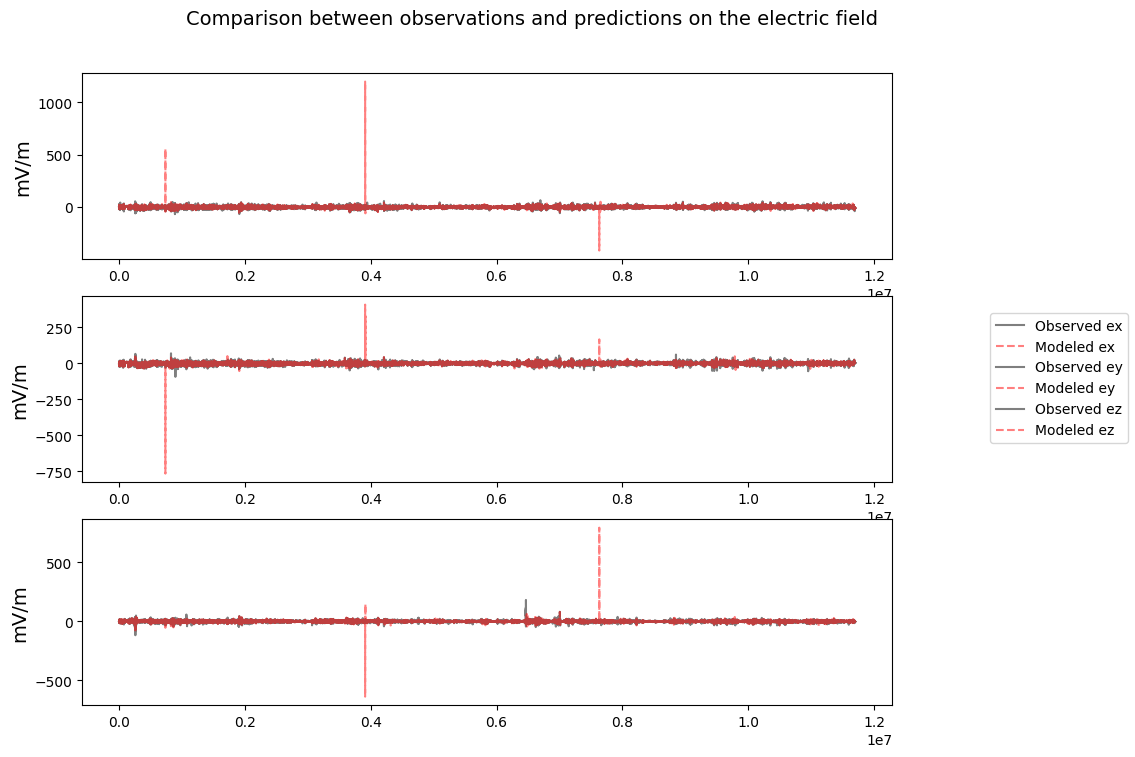

In [31]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        ax[j].plot(np.arange(len(df_test)),df_test.sort_index()[col], label='Observed ' + col, color='k',linestyle='solid',alpha=0.5)
        ax[j].plot(np.arange(len(df_test)),df_predict.sort_index()[col], label='Modeled ' + col, color='r',linestyle='dashed',alpha=0.5)
        #ax[j].plot(np.arange(len(df_test)),df_theo.sort_index()[col], label="Ohm's law " + col, color='g',linestyle='dotted',alpha=0.5)
        #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
        #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
        #ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        #ax[j].set_xlim(t_test_begin, t_test_end)
        #ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        #ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        #ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        #ax[j].set_xlim(6700,6900)
        ax[j].set_ylabel('mV/m', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
        #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

#ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
#ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
#ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
    
fig = plt.gcf()
fig.legend(loc='center right')
fig.subplots_adjust(top=0.9,right=0.8)
fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

plt.show()

In [32]:
## test 1
if False:
        output_targets = ['ex','ey','ez']

        fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
        plt.subplots_adjust(hspace=0.2)

        for j,col in enumerate(output_targets):
                ax[j].plot(df_test.sort_index()[col]-df_predict.sort_index()[col], label='Diff ' + col, color='k')
                #ax[j].plot(d_mhd[col+'_mhd'], label='MHD ' + col, color='g')
                #ax[j].plot(d_hall[col+'_hall'], label='Hall ' + col, color='b')
                ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
                #ax[j].set_xlim(t_test_begin, t_test_end)
                ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
                ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
                ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
                ax[j].set_ylabel('mV/m', fontsize=14)
                ax[j].xaxis.get_label().set_fontsize(16)
                #text = str('Pcc = {}'.format(Pcc_xyz[j])) + str(' , r$^2$ = {}'.format(r2_xyz[j]))
                #ax[j].text(0.75, 0.05, text, fontsize=14, transform=ax[j].transAxes)

        #ax[0].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[0]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[0]].max() + 10)
        #ax[1].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[1]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[1]].max() + 10)
        #ax[2].set_ylim(df_predict[t_test_begin:t_test_end][output_targets[2]].min() - 20, df_predict[t_test_begin:t_test_end][output_targets[2]].max() + 10)
        
        fig = plt.gcf()
        fig.subplots_adjust(top=0.9)
        fig.suptitle("Comparison between observations and predictions on the electric field", fontsize=14)

        plt.show()

In [34]:
## test 1
if False:
        output_targets = ['ex','ey','ez']

        fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
        plt.subplots_adjust(hspace=0.2)

        for j,col in enumerate(output_targets):
                sns.histplot((df_test[col]-df_test[col].mean())/df_test[col].std(),ax=ax[j],stat='density',color='blue',alpha=0.5)
                sns.histplot((df_predict[col]-df_predict[col].mean())/df_predict[col].std(),ax=ax[j],stat='density',color='red',alpha=0.8)

        ax[0].set_yscale('log')
        ax[1].set_yscale('log')
        ax[2].set_yscale('log')
        ax[0].set_xlim(-10,10)
        ax[1].set_xlim(-10,10)
        ax[2].set_xlim(-10,10)
        plt.tight_layout()
        plt.show()

In [35]:
df_res = df_test[output_targets]-df_predict[output_targets]

In [ ]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot(df_res[col],ax=ax[j],stat='density',color='blue',alpha=0.8,label=col)

ax[0].set_xlim(-5,5)
ax[1].set_xlim(-5,5)
ax[2].set_xlim(-5,5)

plt.tight_layout()
plt.show()

## Metrics bar chart

In [37]:
from sklearn.metrics import r2_score

In [38]:
val = np.array([0,0,0])
for k in range(len(df_test)//batch_size):
    val = val + np.array([r2_score(df_theo['ex'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))],df_test['ex'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))]),
            r2_score(df_theo['ey'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))],df_test['ey'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))]),
            r2_score(df_theo['ez'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))],df_test['ez'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))])
            ])
val = val/(k+1)
print(val)

[0.38323057 0.35563552 0.38309752]


In [39]:
val = np.array([0,0,0])
for k in range(len(df_test)//batch_size):
    val = val + np.array([np.corrcoef(df_test['ex'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))],df_theo['ex'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))])[0,1],
            np.corrcoef(df_test['ey'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))],df_theo['ey'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))])[0,1],
            np.corrcoef(df_test['ez'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))],df_theo['ez'].iloc[k*batch_size:min((k+1)*batch_size,len(df_test))])[0,1]
            ])
val = val/(k+1)
print(val)

[0.81158814 0.76924426 0.73689666]


In [40]:
metrics = {
    'mms1_phi':{
    'RMSE': np.sqrt([0.30, 0.24, 0.13]),
    'RMSE Ohm': np.sqrt([1.26, 1.07, 1.39]),
    'Max Error': [3.39, 2.60, 4.16],
    'Max Error Ohm': [19.0, 16.6, 17.8]},
    'mms1_corr':{
    'PCC': [0.98, 0.97, 0.96],
    'PCC Ohm': [0.94, 0.92, 0.87],
    'R$^2$': [0.94, 0.93, 0.87],
    'R$^2$ Ohm': [0.86, 0.84, 0.73]
    },

    'mms2_phi':{
    'RMSE': np.sqrt([0.2759, 0.1870, 0.0430]),
    'RMSE Ohm': np.sqrt([1.86, 1.68, 1.87]),
    'Max Error': [1.9311, 1.5171, 1.3322],
    'Max Error Ohm': [22.3 , 18.96, 20.02]},
    'mms2_corr':{
    'PCC': [0.8959, 0.9041, 0.9356],
    'PCC Ohm': [0.92, 0.88, 0.83],
    'R$^2$': [0.8769, 0.8530, 0.7245],
    'R$^2$ Ohm': [0.84, 0.77, 0.64]
    },

    'mms3_phi':{
    'RMSE': np.sqrt([0.2791, 0.1964, 0.0899]),
    'RMSE Ohm': np.sqrt([2.18, 1.86, 2.17]),
    'Max Error': [2.0373, 1.6221, 4.1108],
    'Max Error Ohm': [24.38, 22.54, 20.59]},
    'mms3_corr':{
    'PCC': [0.9682, 0.9334, 0.9280],
    'PCC Ohm': [0.89, 0.82, 0.78],
    'R$^2$': [0.8700, 0.8454, 0.7125],
    'R$^2$ Ohm': [0.78, 0.66, 0.56]
    },

    'mms4_phi':{
    'RMSE': np.sqrt([0.3022, 0.2217, 0.0706]),
    'RMSE Ohm': np.sqrt([34.586097,22.165299,10.361896]),
    'Max Error': [1.7987, 1.5210, 0.8128],
    'Max Error Ohm': [186.261734,149.167477,182.483046]},
    'mms4_corr':{
    'PCC': [0.8780, 0.9089, 0.9222],
    'PCC Ohm': [0.81158814, 0.76924426, 0.73689666],
    'R$^2$': [0.8679, 0.8458, 0.7047],
    'R$^2$ Ohm': [0.38323057, 0.35563552, 0.38309752]
    }
}

In [41]:
metrics[f'{sat}_phi'].keys()

dict_keys(['RMSE', 'RMSE Ohm', 'Max Error', 'Max Error Ohm'])

(0.1, 400)

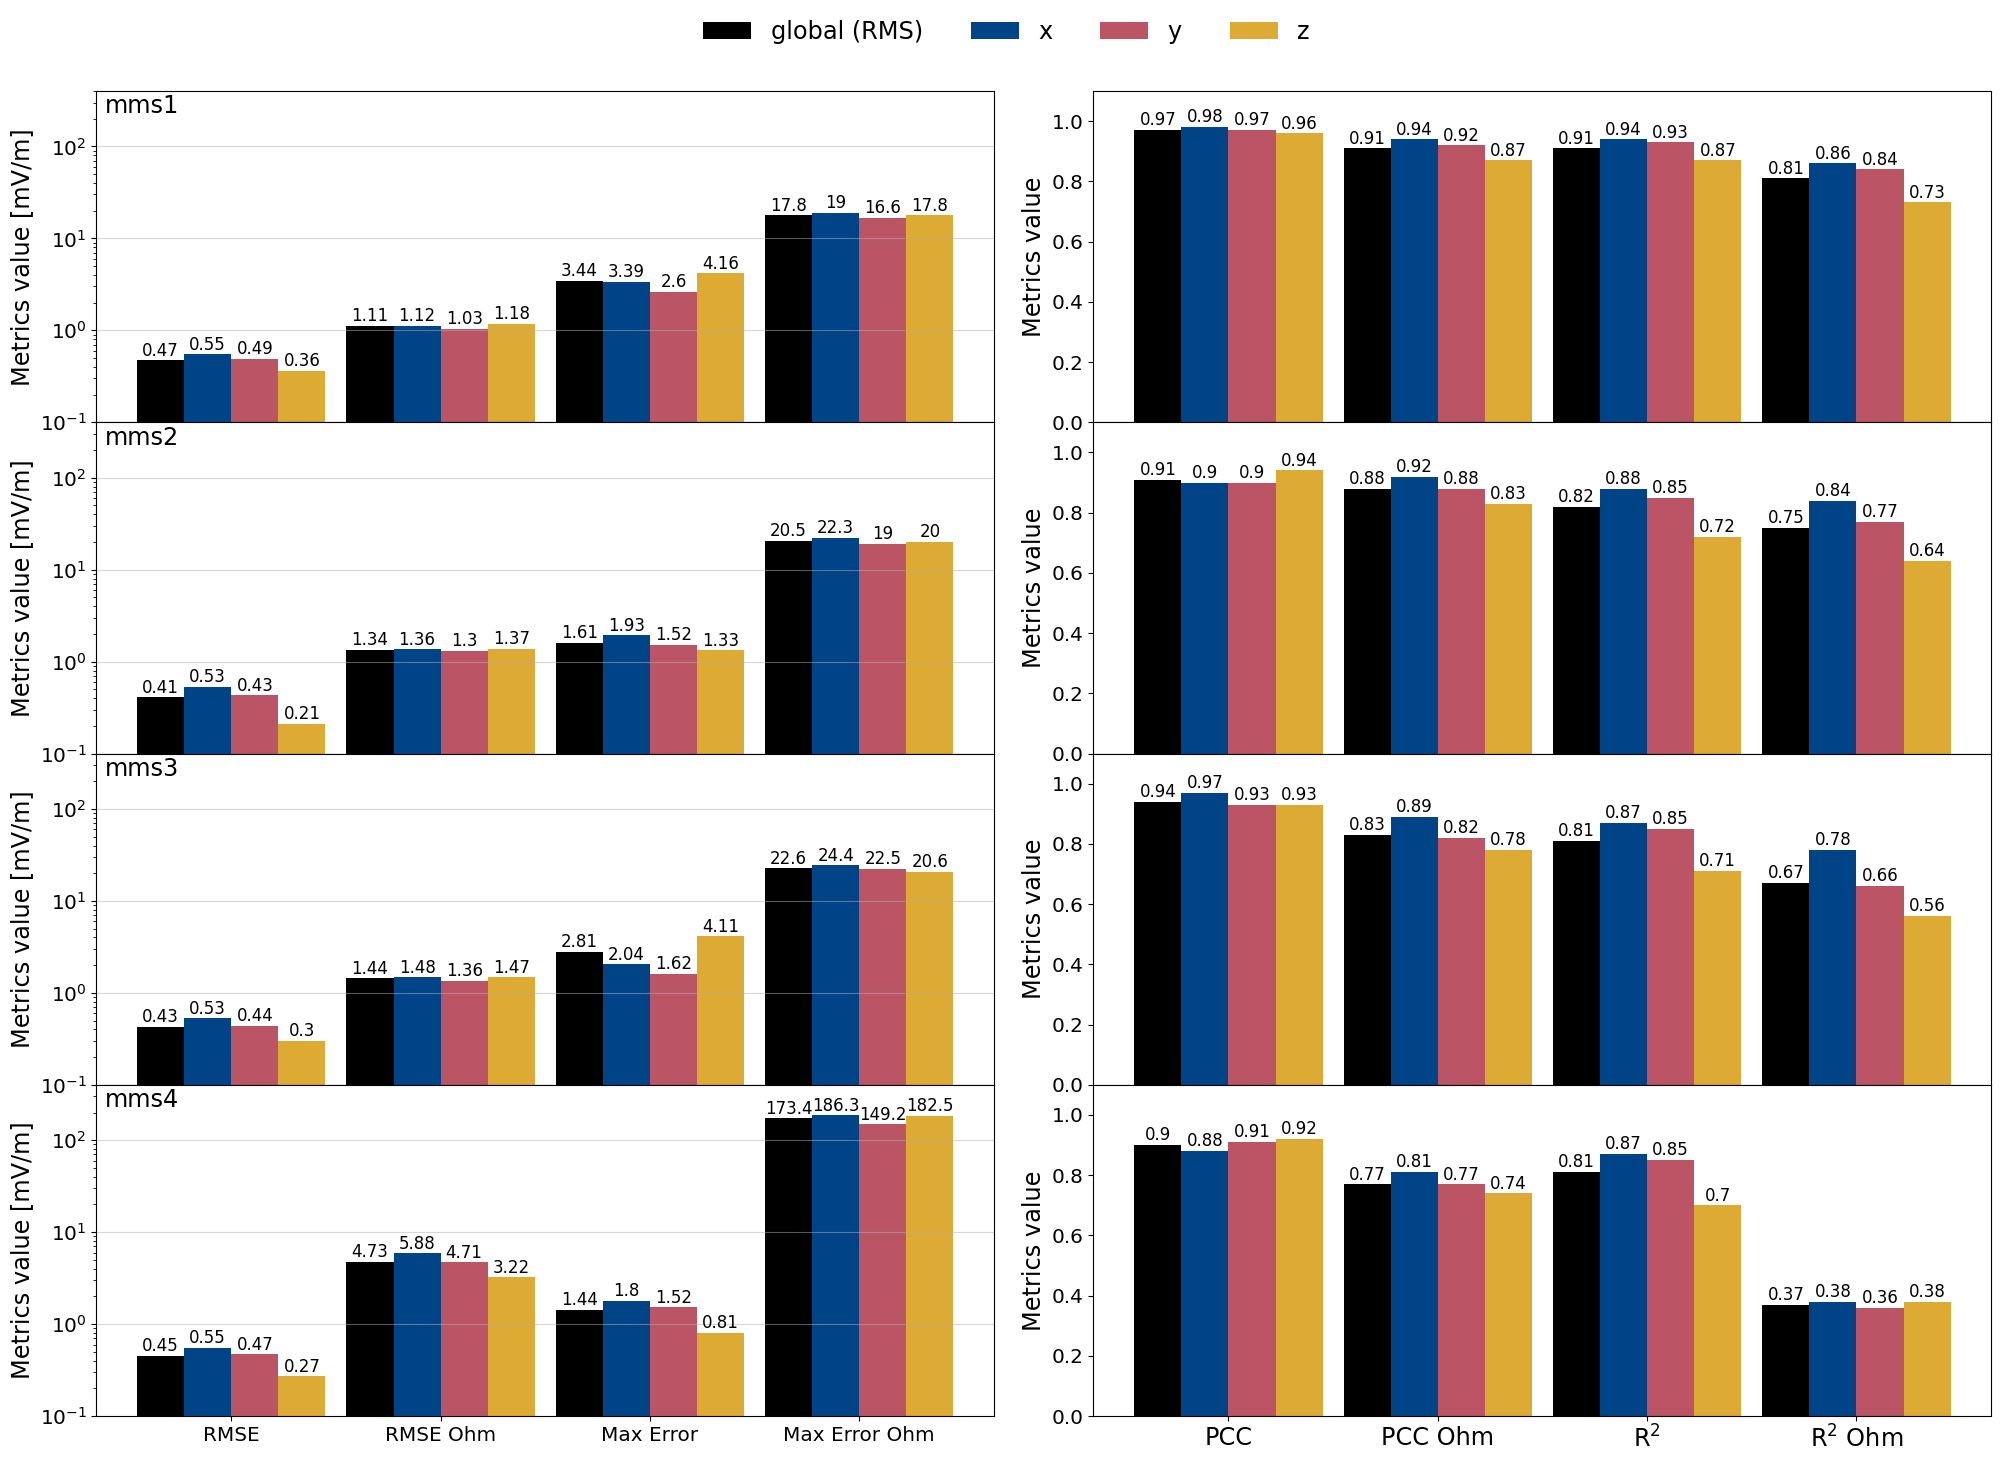

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,14))
x = 0

width = 1/4 - 0.025 # the width of the bars
colors = ['#004488','#bb5566','#ddaa33']




for k in range(4):
    axes[k,0].grid(visible=True,which='major',axis='y',alpha=0.5)
    axes[k,0].grid(visible=True,which='major',axis='y',alpha=0.5)

for k, sat in enumerate(['mms1','mms2','mms3','mms4']):
    for i, (attribute, measurement) in enumerate(metrics[f'{sat}_phi'].items()):
        if i != 3:
            rects = axes[k,0].bar(i - width, round(np.sqrt((np.array(measurement)**2).mean()),2), width ,label=attribute, color='black')
            axes[k,0].bar_label(rects, padding=0.5,size='large')
            for j, val in enumerate(measurement):
                rects = axes[k,0].bar(i + j*width, round(val,2), width ,label=attribute, color=colors[j])
                axes[k,0].bar_label(rects, padding=0.5,size='large')
            
        else:
            rects = axes[k,0].bar(i - width, round(np.sqrt((np.array(measurement)**2).mean()),1), width ,label=attribute, color='black')
            axes[k,0].bar_label(rects, padding=0.5,size='large')
            for j, val in enumerate(measurement):
                rects = axes[k,0].bar(i + j*width, round(val,1), width ,label=attribute, color=colors[j])
                axes[k,0].bar_label(rects, padding=0.5,size='large')

    axes[k,0].set_ylabel('Metrics value [mV/m]',size='xx-large')
    axes[k,0].set_xticks(np.arange(4) + width/2, metrics[f'{sat}_phi'].keys(),size='xx-large')
    axes[k,0].text(0.01,0.99,sat,ha='left',va='top',fontsize='xx-large',transform=axes[k,0].transAxes)
    axes[k,0].set_yscale('log')
    axes[k,0].tick_params(labelsize='x-large')

    #axes[k,1].axhline(1,color='black',linestyle='dashed',alpha=0.5,linewidth=0.5)
    for i, (attribute, measurement) in enumerate(metrics[f'{sat}_corr'].items()):
        rects = axes[k,1].bar(i - width, round(np.sqrt((np.array(measurement)**2).mean()),2), width ,label=attribute, color='black')
        axes[k,1].bar_label(rects, padding=0.5 ,size='large')

        for j, val in enumerate(measurement):
            rects = axes[k,1].bar(i + j*width, round(val,2), width ,label=attribute, color=colors[j])
            axes[k,1].bar_label(rects, padding=0.5, size='large')
        axes[k,1].set_ylabel('Metrics value',size='xx-large')

    axes[k,1].set_xticks(np.arange(4) + width/2, metrics[f'{sat}_corr'].keys(),size='xx-large')
    axes[k,1].set_ylim(0,1.1)
    axes[k,1].tick_params(axis="y",which='both', left=True, right=False, labelleft=True, labelright=False, labelsize='x-large')
    axes[k,1].yaxis.set_label_position('left')

fig.legend(axes[0,1].get_legend_handles_labels()[0][:4],['global (RMS)','x','y','z'],frameon=False,loc=9,ncols=4, fontsize='xx-large',bbox_to_anchor=(0.5, 1.05))
fig.tight_layout()

plt.subplots_adjust(hspace=0)
axes[0,0].set_ylim(bottom=0.1,top=400)
axes[1,0].set_ylim(bottom=0.1,top=400)
axes[2,0].set_ylim(bottom=0.1,top=400)
axes[3,0].set_ylim(bottom=0.1,top=400)



#plt.savefig('./fig/metrics.pdf',dpi=200,bbox_inches='tight')
#plt.savefig('./fig/metrics.svg',dpi=200,bbox_inches='tight')


In [43]:
for sat in ['mms1','mms2','mms3','mms4']:
    metrics[f'{sat}_corr'].pop('PCC')
    metrics[f'{sat}_corr'].pop('PCC Ohm')

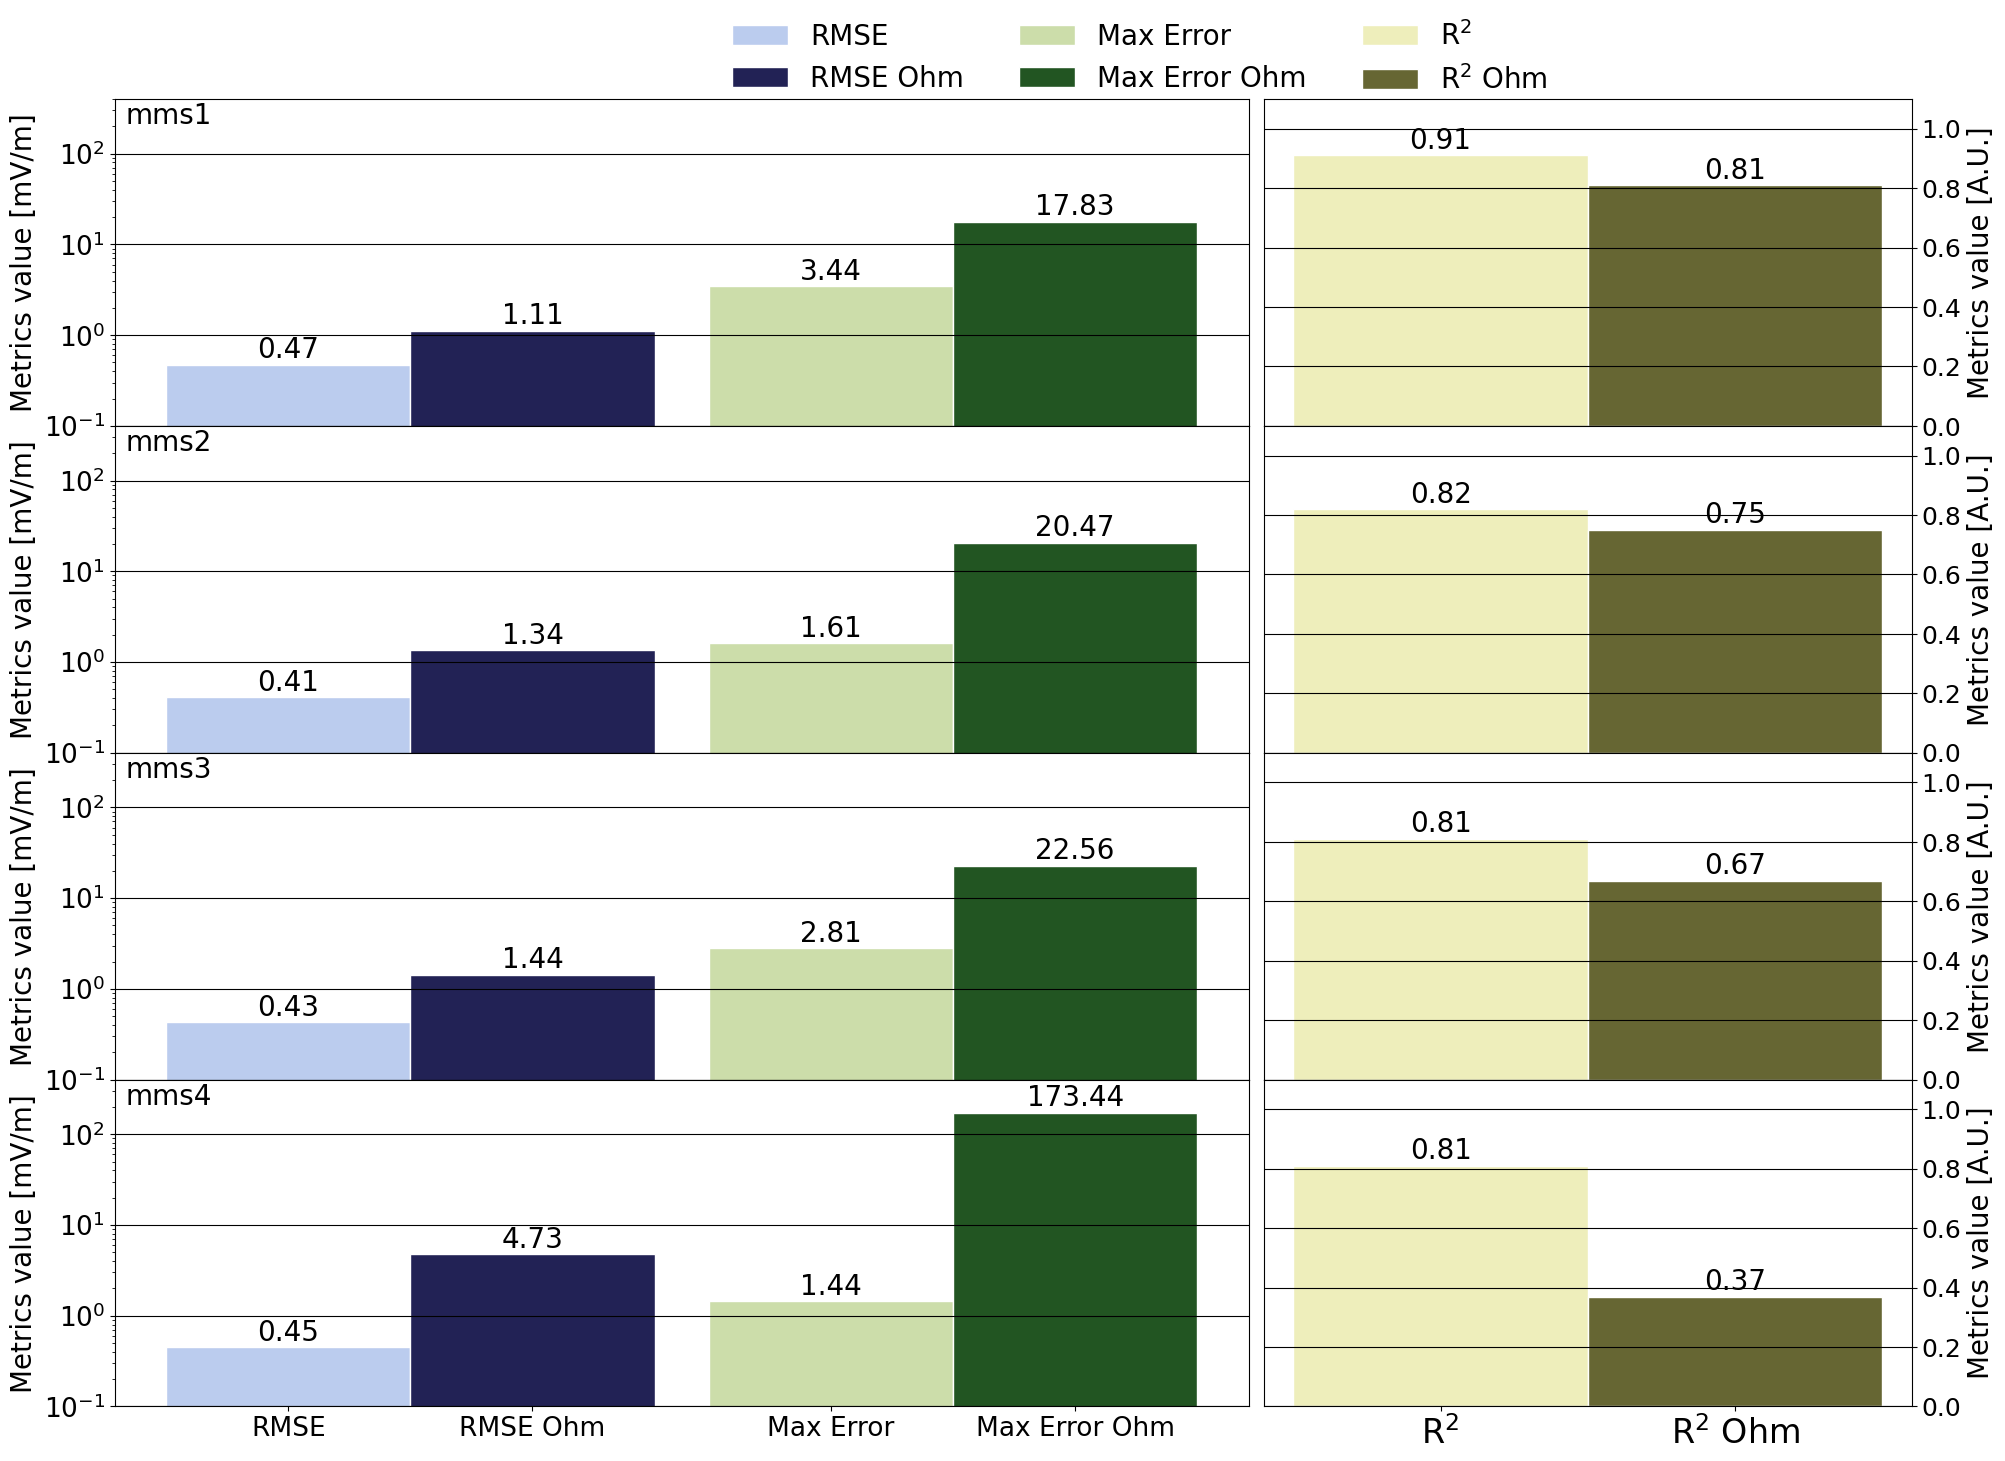

In [73]:


fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,14),gridspec_kw={'width_ratios': [1.75, 1]})
x = 0

width = 1/4 - 0.025 # the width of the bars

colors = ['#BBCCEE','#222255','#CCDDAA','#225522','#EEEEBB','#666633','#FFCCCC','#663333']


for k in range(4):
    #axes[k,0].grid(visible=True,which='major',axis='y',alpha=0.5)
    axes[k,0].grid(visible=True,which='major',axis='y',color='black')
    #axes[k,1].grid(visible=True,which='major',axis='y',alpha=0.5)
    axes[k,1].grid(visible=True,which='major',axis='y',color='black')

for k, sat in enumerate(['mms1','mms2','mms3','mms4']):
    for i, (attribute, measurement) in enumerate(metrics[f'{sat}_phi'].items()):

        rects = axes[k,0].bar(i//2 + (2*(i%2)-1)*width, round(np.sqrt((np.array(measurement)**2).mean()),2), 2*width ,label=attribute, color=colors[i], edgecolor='white')
        axes[k,0].bar_label(rects, padding=0.5,size=20)





    if k != 3:
        axes[k,0].tick_params(axis="x",labelbottom=False)
    axes[k,0].set_ylabel('Metrics value [mV/m]',size=20)
    axes[k,0].set_xticks(np.arange(4)//2 + (2*(np.arange(4)%2)-1)*width, metrics[f'{sat}_phi'].keys(),size=24)
    axes[k,0].text(0.01,0.99,sat,ha='left',va='top',fontsize=20,transform=axes[k,0].transAxes)
    axes[k,0].set_yscale('log')
    axes[k,0].tick_params(labelsize=19)
    
    #axes[k,1].axhline(1,color='black',linestyle='dashed',alpha=0.5,linewidth=0.5)


    
    for i, (attribute, measurement) in enumerate(metrics[f'{sat}_corr'].items()):
            rects = axes[k,1].bar(i//2 + (2*(i%2)-1)*width, round(np.sqrt((np.array(measurement)**2).mean()),2), 2*width ,label=attribute, color=colors[4+i], edgecolor='white')
            axes[k,1].bar_label(rects, padding=0.5,size=20)




    if k != 3:
        axes[k,1].tick_params(axis="x",labelbottom=False)

    axes[k,1].set_xticks(np.arange(2)//2 + (2*(np.arange(2)%2)-1)*width, metrics[f'{sat}_corr'].keys(),size=24)
    axes[k,1].set_ylim(0,1.1)
    axes[k,1].tick_params(axis="y",which='both',left=False, right=True, labelleft=False, labelright=True, labelsize=18)
    axes[k,1].yaxis.set_label_position('right')
    axes[k,1].set_ylabel('Metrics value [A.U.]',size=20)
    #axes[k,1].grid(visible=True,which='major',axis='y',color='black')
fig.legend(axes[0,0].get_legend_handles_labels()[0][:4]+axes[0,1].get_legend_handles_labels()[0][:4],
           ['RMSE','RMSE Ohm', 'Max Error', 'Max Error Ohm', 'R$^2$', 'R$^2$ Ohm'],
           frameon=False,loc=9,ncols=3, fontsize=20,bbox_to_anchor=(0.565, 1.05))
fig.tight_layout()

plt.subplots_adjust(hspace=0)

axes[0,0].set_ylim(bottom=0.1,top=400)
axes[1,0].set_ylim(bottom=0.1,top=400)
axes[2,0].set_ylim(bottom=0.1,top=400)
axes[3,0].set_ylim(bottom=0.1,top=400)



plt.savefig('./fig/metrics_light.pdf',dpi=200,bbox_inches='tight')
plt.savefig('./fig/metrics_light.svg',dpi=200,bbox_inches='tight')


## Graham & al. (2017) - Lower Hybrid Waves in the Ion Diffusion and Magnetospheric Inflow Regions

In [74]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2015,12,8,0,0,0)
        t2 = datetime(2015,12,8,1,0,0)
        sat = 'mms1'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
df_test = dataset.to_dataframe()
test_data ,_ = random_split(dataset, [1,0])

t01, t02 =  datetime(2015,12,8,0,5,50), datetime(2015,12,8,0,6,30)

df_test = df_test[t01:t02]
test_data.dataset.values = test_data.dataset[np.argwhere((test_data.dataset.index > t01)&(test_data.dataset.index < t02))][:,0,:]
test_data.dataset.index = test_data.dataset.index.where((test_data.dataset.index > t01)&(test_data.dataset.index < t02)).dropna()

print(test_data.dataset.values)

scale.to('cpu')
X_test, y_test = scale.transform(test_data)
scale.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

test_graham = torch.Tensor(model.predict(X_test,batch_size))

model.summary()

metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

tensor([[-13.3088,   9.2415, -33.6671,  ...,  -3.5920,   0.3599,   1.6683],
        [-13.2762,   9.2686, -33.5891,  ...,  -3.5513,   0.3933,   1.7039],
        [-13.3333,   9.3289, -33.5378,  ...,  -3.3580,   0.4478,   1.6135],
        ...,
        [ 15.1524, -23.4333,  48.7458,  ...,  -5.0702,   6.2439,   4.1279],
        [ 15.1365, -23.4524,  48.7310,  ...,  -5.0743,   6.1224,   4.2849],
        [ 15.1280, -23.4728,  48.7148,  ...,  -5.0764,   5.9689,   4.3963]],
       dtype=torch.float64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350,498 (24.23 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,233,666 (16.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - MSE: 1.8300 - PCC: 0.9310 - loss: 0.1699 - max_error: 8.9409 - r2_score: 0.8618
{'MSE': tensor([1.8560, 1.4803, 2.1537], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9328, 0.9753, 0.8849]), 'loss': 0.16994743049144745, 'max_error': tensor([ 6.9144, 12.0213,  7.8870], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8653, 0.9428, 0.7773], device='cuda:0')}


In [75]:
scale.to('cpu')
X_test = X_test.to('cpu')

_, predict = scale.untransform(X_test,test_graham)
# test 
df_predict = df_test.copy()
df_predict[['ex','ey','ez']] = predict

In [76]:
n = len(df_test[['ex','ey','ez']])
freq = rfftfreq(n-1,d=0.03)
nfilt = len(irfft(rfft(df_test[['ex','ey','ez']],n=n,axis=0)[np.where(freq<=10)],axis=0))
filtered_signal = pd.DataFrame(irfft(rfft(df_test[['ex','ey','ez']],n=n,axis=0)[np.where(freq<=10)],axis=0),columns=['ex','ey','ez'],index=[df_test.index[0] + timedelta(seconds=k/10) for k in range(nfilt)] )
filtered_pred = pd.DataFrame(irfft(rfft(df_predict[['ex','ey','ez']],n=n,axis=0)[np.where(freq<=10)],axis=0),columns=['ex','ey','ez'],index=[df_test.index[0] + timedelta(seconds=k/10) for k in range(nfilt)] )
filtered_ohm = pd.DataFrame(irfft(rfft(df_test[['ex_hall','ey_hall','ez_hall']].__array__()+df_test[['ex_mhd','ey_mhd','ez_mhd']].__array__(),n=n,axis=0)[np.where(freq<=10)],axis=0),columns=['ex','ey','ez'],index=[df_test.index[0] + timedelta(seconds=k/10) for k in range(nfilt)] )

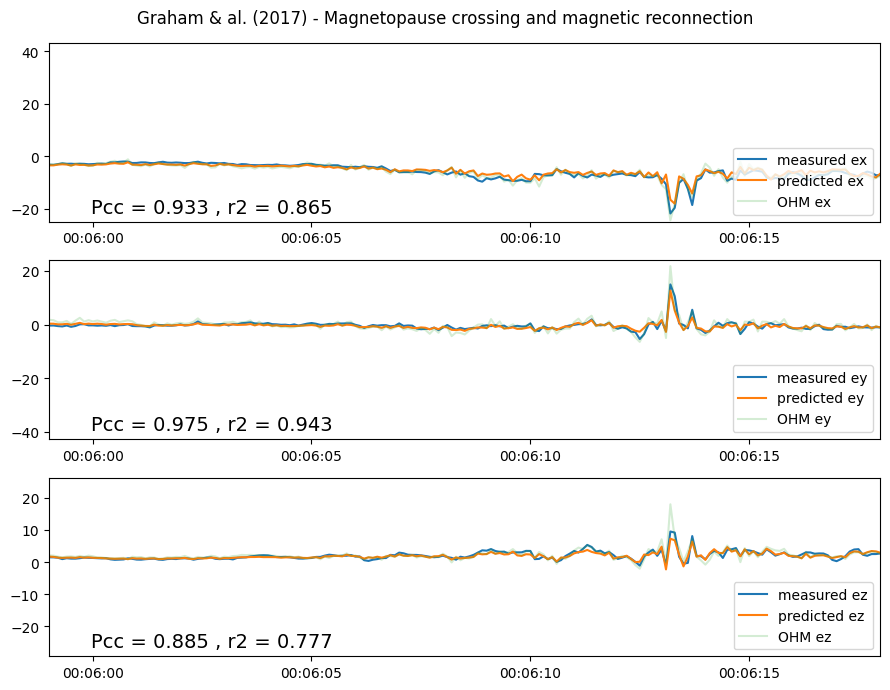

In [77]:
fig, axes = plt.subplots(nrows=3,figsize=(9,7))
for j,col in enumerate(['ex','ey','ez']):
    axes[j].plot(filtered_signal[col],label=f"measured {col}")
    axes[j].plot(filtered_pred[col],label=f"predicted {col}")
    lims = axes[j].get_ylim()
    axes[j].plot(filtered_ohm[col],label=f"OHM {col}",alpha=0.2)
    text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][j]))
    axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
    axes[j].set_ylim(lims)
    axes[j].legend(loc=4)
    axes[j].set_xlim(datetime(2015,12,8,0,5,59), datetime(2015,12,8,0,6,18))
fig.suptitle("Graham & al. (2017) - Magnetopause crossing and magnetic reconnection")
fig.tight_layout()

In [78]:
from scipy.spatial.transform import Rotation
Rot = Rotation.from_matrix(np.array([[0.25,-0.4,0.88],[0.35,-0.89,0.3],[0.9,-0.23,-0.36]]))

filtered_signal[['eL','eM','eN']] = Rot.apply(filtered_signal[['ex','ey','ez']])
filtered_pred[['eL','eM','eN']] = Rot.apply(filtered_pred[['ex','ey','ez']])
filtered_ohm[['eL','eM','eN']] = Rot.apply(filtered_ohm[['ex','ey','ez']])

df_ohm = pd.DataFrame(index=df_test.index)

df_test[['eL','eM','eN']] = Rot.apply(df_test[['ex','ey','ez']])
df_predict[['eL','eM','eN']] = Rot.apply(df_predict[['ex','ey','ez']])
df_ohm[['eL','eM','eN']] = Rot.apply((df_test[['ex_mhd','ey_mhd','ez_mhd']].__array__()+df_test[['ex_hall','ey_hall','ez_hall']].__array__()))

In [79]:
r2_LMN_filtered = r2_score(filtered_signal[['eL','eM','eN']],filtered_pred[['eL','eM','eN']],multioutput='raw_values')
r2_LMN_filtered_ohm = r2_score(filtered_signal[['eL','eM','eN']],filtered_ohm[['eL','eM','eN']],multioutput='raw_values')
pcc_LMN_filtered = np.array([np.corrcoef(filtered_signal['eL'], filtered_pred['eL'])[0,1],np.corrcoef(filtered_signal['eM'], filtered_pred['eM'])[0,1],np.corrcoef(filtered_signal['eN'], filtered_pred['eN'])[0,1]])
pcc_LMN_filtered_ohm = np.array([np.corrcoef(filtered_signal['eL'], filtered_ohm['eL'])[0,1],
                        np.corrcoef(filtered_signal['eM'], filtered_ohm['eM'])[0,1],
                        np.corrcoef(filtered_signal['eN'], filtered_ohm['eN'])[0,1]])


r2_LMN = r2_score(df_test[['eL','eM','eN']],df_predict[['eL','eM','eN']],multioutput='raw_values')
r2_LMN_ohm = r2_score(df_test[['eL','eM','eN']],df_ohm[['eL','eM','eN']],multioutput='raw_values')
pcc_LMN = np.array([np.corrcoef(df_test['eL'], df_predict['eL'])[0,1],np.corrcoef(df_test['eM'], df_predict['eM'])[0,1],np.corrcoef(df_test['eN'], df_predict['eN'])[0,1]])
pcc_LMN_ohm = np.array([np.corrcoef(df_test['eL'], df_ohm['eL'])[0,1],
                        np.corrcoef(df_test['eM'], df_ohm['eM'])[0,1],
                        np.corrcoef(df_test['eN'], df_ohm['eN'])[0,1]])
print('--- No filter ---')
print(r2_LMN)
print(r2_LMN_ohm)
print(pcc_LMN)
print(pcc_LMN_ohm)
print('--- 10 Hz filter ---')                     
print(r2_LMN_filtered)
print(r2_LMN_filtered_ohm)
print(pcc_LMN_filtered)
print(pcc_LMN_filtered_ohm)

--- No filter ---
[0.82327684 0.92533239 0.89358209]
[-1.77119093 -2.34379348 -2.58879576]
[0.90964506 0.96553266 0.94965737]
[0.55980915 0.60058352 0.48197747]
--- 10 Hz filter ---
[0.83324092 0.94228616 0.91261489]
[-0.82487442 -1.08390154 -1.34878667]
[0.91579215 0.97486945 0.96061624]
[0.64764918 0.70221892 0.56318176]


In [80]:
df_test['eL'].argmin()

620

In [118]:
np.argwhere(df_test['eL'].index<datetime(2015,12,8,0,6,18))

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

[[0.04027006 0.82914149]
 [0.99166667 0.97008681]]
[[0.04027006 0.68819618]
 [0.99166667 0.82914149]]
[[0.04027006 0.54725087]
 [0.99166667 0.68819618]]
[[0.04027006 0.40630556]
 [0.99166667 0.54725087]]
[[0.04027006 0.26536024]
 [0.99166667 0.40630556]]
[[0.04027006 0.12441493]
 [0.99166667 0.26536024]]


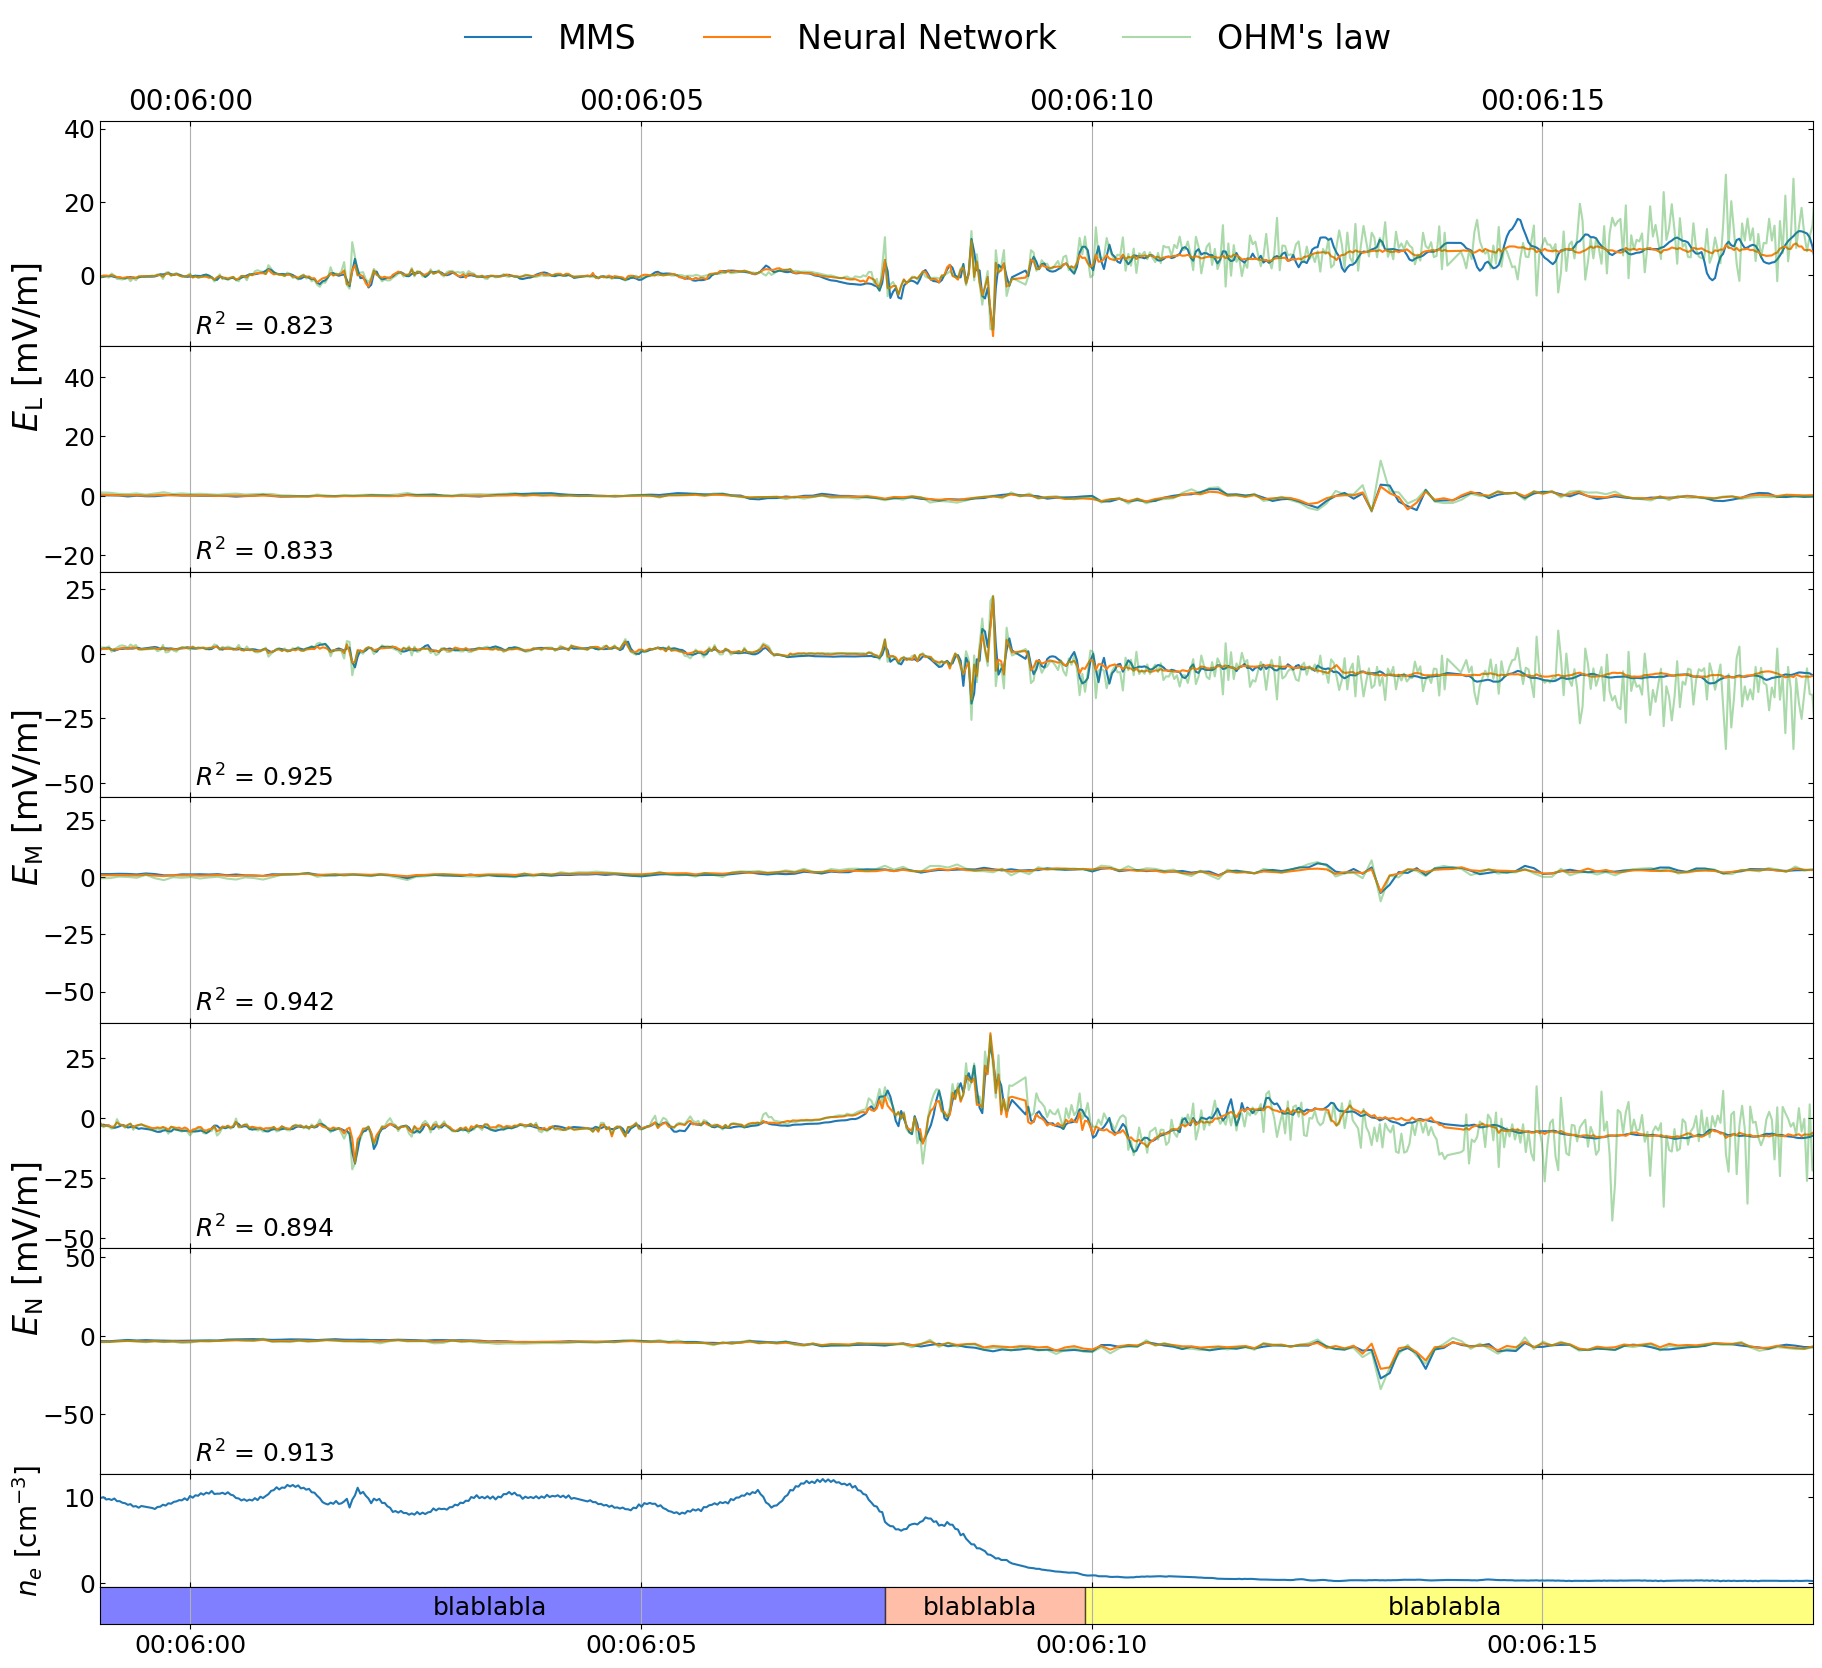

In [199]:
fig, axes = plt.subplots(nrows=8,figsize=(18,16),sharex=True,gridspec_kw={'height_ratios': [3, 3, 3, 3, 3, 3, 1.5, 0.5]})

### Raw data
for i in range(8):
    axes[i].grid(visible=True,axis='x')
i=0

col_lbl = ['$E_{\\mathrm{L}}$','$E_{\\mathrm{M}}$','$E_{\\mathrm{N}}$']
for j,col in enumerate(['eL','eM','eN']):
    idx = 2*j
    axes[idx].plot(df_test[col],label=f"MMS")
    axes[idx].plot(df_predict[col],label=f"Neural Network")
    lims = axes[idx].get_ylim()
    axes[idx].plot(df_ohm[col],label=f"OHM's law",alpha=0.4)

    text = str('$R^2$ = {:.3}'.format(r2_LMN[j]))
    axes[idx].text(0.055, 0.05, text, fontsize=18, transform=axes[idx].transAxes)
    #axes[idx].set_ylim(lims)
    axes[idx].set_xlim(datetime(2015,12,8,0,5,59), datetime(2015,12,8,0,6,18))
    axes[idx].set_ylabel('',fontsize=20)
    if j==0:
        axes[idx].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=True, labelsize=20)
        axes[idx].xaxis.set_label_position('top')
    if j==1:
        axes[idx].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=False)   
    if j==2:
        axes[idx].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=False)

    axes[idx].tick_params(axis="y",which='both',direction='in', left=True, right=True, labelleft=True, labelright=False, labelsize=18)   


axes[-2].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=True, labeltop=False,labelsize=18)
axes[-2].tick_params(axis="y",which='both',direction='in', left=True, right=True, labelleft=True, labelright=False,labelsize=18)
axes[-2].plot(df_test.index,df_test['e_density'],label='electronic density')

### Filtered

for j,col in enumerate(['eL','eM','eN']):
    idx = 2*j + 1;
    axes[idx].plot(filtered_signal[col],label=f"MMS data")
    axes[idx].plot(filtered_pred[col],label=f"Neural Network prediction")
    lims = axes[j].get_ylim()
    axes[idx].plot(filtered_ohm[col],label=f"OHM's local law (MHD+Hall)",alpha=0.4)
    text = str('$R^2$ = {:.3}'.format(r2_LMN_filtered[j]))
    axes[idx].text(0.055, 0.05, text, fontsize=18, transform=axes[idx].transAxes)
    #axes[idx].set_ylim(lims)
    #axes[idx].legend(loc=2)
    axes[idx].set_xlim(datetime(2015,12,8,0,5,59), datetime(2015,12,8,0,6,18))

    axes[idx].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=False)
    
    axes[idx].set_ylabel('',fontsize=20)
    axes[idx].tick_params(axis="y",which='both',direction='in', left=True, right=True, labelleft=True, labelright=False,labelsize=18)
    axes[idx].yaxis.set_label_position("left")

axes[-1].tick_params(axis="y",left=False,right=False,labelleft=False,labelright=False)
axes[-1].tick_params(axis="x",labelsize=18)
axes[-1].fill_betweenx(y=(0,1),x1=df_test['eL'].index[296],x2=df_test['eL'].index[580],color='blue', edgecolor='black', alpha=0.5)
axes[-1].text(x=df_test['eL'].index[(296+580)//2],y=0.45,s="blablabla",va='center',ha='center',fontsize=18)
axes[-1].fill_betweenx(y=(0,1),x1=df_test['eL'].index[580],x2=df_test['eL'].index[650],color='coral', edgecolor='black', alpha=0.5)
axes[-1].text(x=df_test['eL'].index[(580+650)//2],y=0.45,s="blablabla",va='center',ha='center',fontsize=18)
axes[-1].fill_betweenx(y=(0,1),x1=df_test['eL'].index[650],x2=df_test['eL'].index[916],color='yellow', edgecolor='black', alpha=0.5)
axes[-1].text(x=df_test['eL'].index[(650+916)//2],y=0.45,s="blablabla",va='center',ha='center',fontsize=18)
axes[-1].set_ylim(0.01,0.99)
#fig.suptitle("Graham & al. (2017) - Magnetopause crossing and magnetic reconnection - LMN Basis")
fig.legend(axes[2].get_legend_handles_labels()[1],frameon=False,loc=9,ncols=3, fontsize=24,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout()
plt.subplots_adjust(hspace=0)

for j,col in enumerate(['eL','eM','eN']):
    idx = 2*j
    print(axes[idx].get_position().get_points())
    print(axes[idx+1].get_position().get_points())
    top = axes[idx].get_position().get_points()[0,1]
    bot = axes[idx+1].get_position().get_points()[1,1]
    avepos = (top+bot)/2
    transform = mtransforms.blended_transform_factory(mtransforms.IdentityTransform(), fig.transFigure)  # specify x, y transform
    plt.figtext(x = 0, y = avepos,s=f"{col_lbl[j]} [mV/m]",fontsize=24, va ='center', ha = 'center', rotation='vertical')
    #axes[idx].yaxis.label.set_transform(transform)  # changed from default blend (IdentityTransform(), axs[0].transAxes)
    #axes[idx].yaxis.label.set_position((0, avepos))
    
    #axes[idx].set_ylabel(f"{col_lbl[j]} [mV/m]",fontsize=20)
    #{col_lbl[j]} [mV/m]

top = axes[-2].get_position().get_points()[1,1]
bot = axes[-2].get_position().get_points()[0,1]
avepos = (top+bot)/2
plt.figtext(x = 0, y = avepos,s='$n_e$ [cm$^{-3}$]',fontsize=20, va ='center', ha = 'center', rotation='vertical')

#plt.savefig('./fig/graham.svg',dpi=200,bbox_inches='tight') #For slides
plt.savefig('./fig/graham.pdf',dpi=200,bbox_inches='tight') #For paper

## Chen, L.-J., et al. (2016) - Electron energization and mixing observed by MMS in the vicinity of an electron diffusion region during magnetopause reconnection

In [100]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2015,9,19,7,0,0)
        t2 = datetime(2015,9,19,9,0,0)
        sat = 'mms2'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
df_test = dataset.to_dataframe()
test_data ,_ = random_split(dataset, [1,0])

t01, t02 =  datetime(2015,9,19,7,44,8), datetime(2015,9,19,7,44,54)

df_test = df_test[t01:t02]
test_data.dataset.values = test_data.dataset[np.argwhere((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02))][:,0,:]
test_data.dataset.index = test_data.dataset.index.where((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02)).dropna()

print(test_data.dataset.values)

scale.to('cpu')
X_test, y_test = scale.transform(test_data)
scale.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

test_chen = torch.Tensor(model.predict(X_test,batch_size))

model.summary()

metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

tensor([[  4.0151, -21.9129, -29.7498,  ...,   3.6980,   2.1493,   0.3531],
        [  3.8055, -22.3221, -29.5174,  ...,   4.2383,   2.5286,  -1.1611],
        [  3.5852, -22.2942, -29.1997,  ...,   3.8553,   3.0992,  -2.0563],
        ...,
        [ 23.0820,  -2.5789,  60.0436,  ...,  -3.2737,  -1.0829,   1.1123],
        [ 23.3277,  -2.2770,  59.8147,  ...,  -3.3875,  -0.6248,   1.3870],
        [ 23.7967,  -1.9436,  59.7278,  ...,  -2.9372,  -0.8203,   1.2383]],
       dtype=torch.float64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350,498 (24.23 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,233,666 (16.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - MSE: 6.0391 - PCC: 0.8359 - loss: 0.4935 - max_error: 13.5694 - r2_score: 0.6863
{'MSE': tensor([7.2085, 6.0599, 4.8488], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.9092, 0.8748, 0.7238]), 'loss': 0.49354037642478943, 'max_error': tensor([11.5353, 14.5249, 14.6480], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.8113, 0.7291, 0.5186], device='cuda:0')}


In [101]:
scale.to('cpu')
X_test = X_test.to('cpu')

_, predict = scale.untransform(X_test,test_chen)
# test 
df_predict = df_test.copy()
df_predict[['ex','ey','ez']] = predict

df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,ex,ey,ez
2015-09-19 07:44:08.000,4.015116,-21.912913,-29.749783,-2.761018e-07,2.356262e-07,-9.989397e-08,-130.327776,143.107590,-142.836238,34.415932,7.387378,4.450727,-2.281268,-1.668250,-1.562385,0.925660,5.591311,3.111250,-1.587634
2015-09-19 07:44:08.030,3.805469,-22.322144,-29.517430,-3.603428e-09,7.613700e-08,-2.984476e-07,-130.077218,142.533146,-143.572826,35.190845,7.412066,4.385907,-2.361197,-1.580179,-0.220300,-0.037122,5.972187,3.732556,-2.371783
2015-09-19 07:44:08.060,3.585211,-22.294190,-29.199731,-6.182488e-08,2.797588e-07,-3.830696e-07,-131.448531,142.447183,-144.158750,33.513653,7.373322,4.355101,-2.419835,-3.111867,-0.591986,0.069903,4.625970,3.145690,-2.002483
2015-09-19 07:44:08.090,3.879387,-22.631520,-30.146716,1.378899e-08,1.100125e-08,4.265039e-07,-132.833469,142.409431,-144.836607,33.127831,7.571049,4.566370,-2.453762,1.756099,0.390052,-0.066836,8.280699,4.853478,-1.771242
2015-09-19 07:44:08.120,3.767374,-23.279524,-30.617916,-1.534112e-07,-1.399664e-07,2.744234e-07,-134.193637,142.359787,-145.416300,33.232731,7.743982,4.656567,-2.587641,2.004693,-0.688008,0.769775,9.119538,4.572197,-1.342670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-19 07:44:53.871,22.628479,-3.359608,60.042108,-2.318838e-09,2.061782e-08,1.270382e-07,-72.498238,77.254847,-109.072822,8.467024,-4.272102,-1.884795,1.504594,1.227169,2.221718,-0.338177,-2.919051,-0.842096,1.191822
2015-09-19 07:44:53.901,22.881115,-2.977170,60.075943,4.254936e-09,5.384802e-08,4.521821e-08,-71.507407,80.475671,-107.069666,8.407333,-4.515887,-1.846002,1.628483,2.501548,0.578338,-0.924103,-2.862930,-1.388945,1.096216
2015-09-19 07:44:53.931,23.082044,-2.578871,60.043617,-7.553894e-09,2.313512e-08,1.404977e-07,-70.509337,83.721848,-105.135965,8.490384,-4.755830,-1.806883,1.750637,1.287532,2.717423,-0.378241,-3.206480,-0.574839,1.318234
2015-09-19 07:44:53.961,23.327676,-2.277013,59.814677,4.655340e-08,3.997122e-08,1.037134e-07,-68.744885,87.595192,-106.415255,8.218544,-4.997169,-1.629533,1.886859,1.995072,-0.277336,-0.788634,-3.424143,-1.336086,1.340191


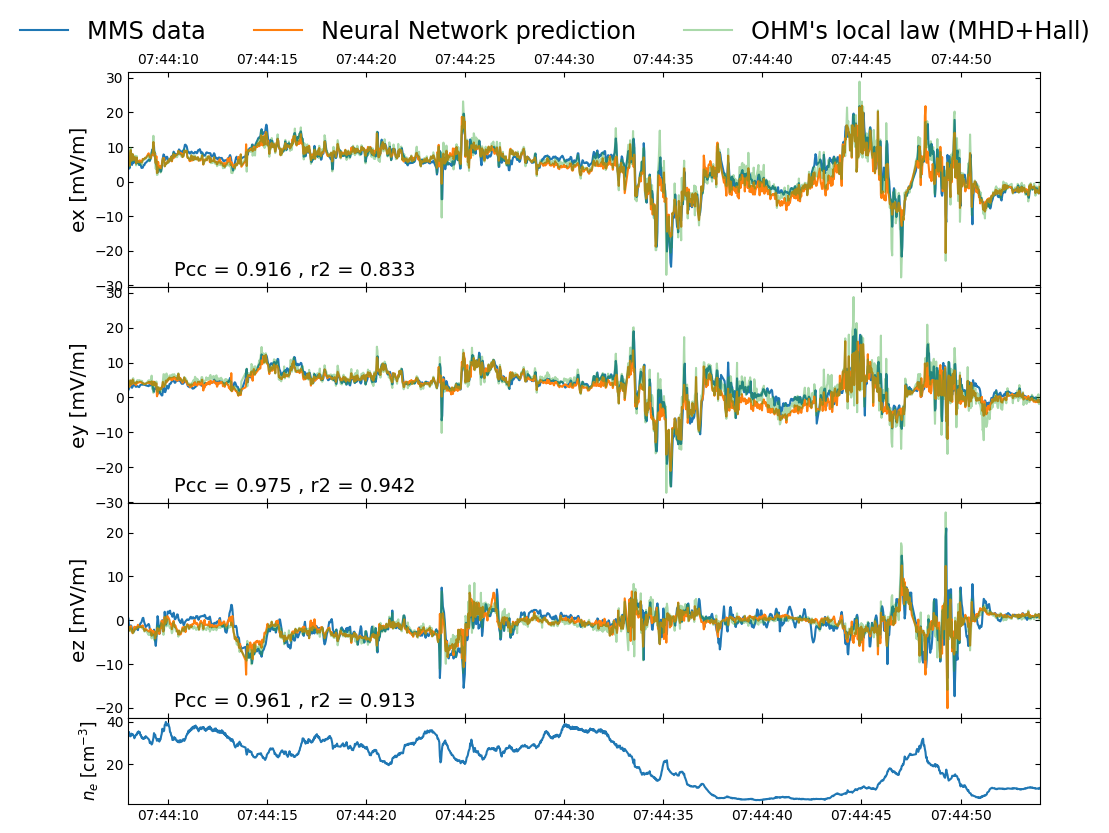

In [102]:
fig, axes = plt.subplots(nrows=4,figsize=(10,8),sharex=True,gridspec_kw={'height_ratios': [3, 3, 3, 1.2]})
for j,col in enumerate(['ex','ey','ez']):
    axes[j].plot(df_test[col],label=f"MMS data")
    axes[j].plot(df_predict[col],label=f"Neural Network prediction")

    axes[j].plot(df_predict.index,df_predict[col+'_mhd'].__array__()+df_predict[col+'_hall'].__array__(),label=f"OHM's local law (MHD+Hall)",alpha=0.4)
    text = str('Pcc = {:.3}'.format(pcc_LMN_filtered[j])) + str(' , r2 = {:.3}'.format(r2_LMN_filtered[j]))
    axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)

    #axes[j].legend(loc=2)
    axes[j].set_xlim(datetime(2015,9,19,7,44,8), datetime(2015,9,19,7,44,54))
    if j==0:
        axes[j].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=True)
        axes[j].xaxis.set_label_position('top')
    if j==1:
        axes[j].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=False)   
    if j==2:
        axes[j].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=False)
    
    axes[j].set_ylabel(f'{col} [mV/m]',fontsize='x-large')
    axes[j].tick_params(axis="y",which='both',direction='in', left=True, right=True, labelleft=True)
    #axes[j].yaxis.set_label_position("right")

axes[3].plot(df_test.index,df_test['e_density'])

axes[3].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=True, labeltop=False)
axes[3].tick_params(axis="y",which='both',direction='in', left=True, right=True, labelleft=True, labelright=False)

axes[3].set_ylabel('$n_e$ [cm$^{-3}$]',fontsize='large')
    
fig.legend(axes[2].get_legend_handles_labels()[1],frameon=False,loc=9,ncols=3, fontsize='xx-large',bbox_to_anchor=(0.5, 1.05))
#fig.suptitle(f"Chen, L.-J., et al. (2016), Electron energization and mixing observed by MMS \n in the vicinity of an electron diffusion region during magnetopause reconnection \n {sat}")
fig.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0)

plt.savefig('./fig/chen.svg',dpi=200,bbox_inches='tight') #For slides
plt.savefig('./fig/chen.pdf',dpi=200,bbox_inches='tight') #For paper

## Burch et al. (2016) - Electron-scale measurements of magnetic reconnection in space

In [42]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2015,10,16,12,0,0)
        t2 = datetime(2015,10,16,14,0,0)
        sat = 'mms1'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
df_test = dataset.to_dataframe()
test_data ,_ = random_split(dataset, [1,0])

t01, t02 =  datetime(2015,10,16,13,6,30), datetime(2015,10,16,13,7,30)

df_test = df_test[t01:t02]
test_data.dataset.values = test_data.dataset[np.argwhere((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02))][:,0,:]
test_data.dataset.index = test_data.dataset.index.where((test_data.dataset.index >= t01)&(test_data.dataset.index <= t02)).dropna()

print(test_data.dataset.values)

scale.to('cpu')
X_test, y_test = scale.transform(test_data)
scale.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

test_burch = torch.Tensor(model.predict(X_test,batch_size))

model.summary()

metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True)
print(metrics)

tensor([[-10.6977,  10.1115, -24.0509,  ...,   1.8452,   2.6747,   0.4045],
        [-10.7519,  10.1455, -24.0281,  ...,   1.7991,   2.6807,   0.3612],
        [-10.8334,  10.1872, -23.9892,  ...,   1.5452,   2.3642,   0.3058],
        ...,
        [  0.1922,  23.5546,  -5.0526,  ...,  -3.1607,   0.8786,   5.4721],
        [  0.3223,  23.5485,  -4.3021,  ...,  -3.2803,   0.7549,   5.5984],
        [  0.6167,  23.7141,  -3.9457,  ...,  -3.6904,   0.8712,   6.2398]],
       dtype=torch.float64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350,498 (24.23 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,233,666 (16.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - MSE: 1.1835 - PCC: 0.8746 - loss: 0.0940 - max_error: 8.7831 - r2_score: 0.7636
{'MSE': tensor([1.2510, 1.5025, 0.7971], device='cuda:0', dtype=torch.float64), 'PCC': tensor([0.8797, 0.8825, 0.8615]), 'loss': 0.0939897820353508, 'max_error': tensor([ 9.2750, 10.0381,  7.0361], device='cuda:0', dtype=torch.float64), 'r2_score': tensor([0.7705, 0.7783, 0.7419], device='cuda:0')}


In [43]:
scale.to('cpu')
X_test = X_test.to('cpu')

_, predict = scale.untransform(X_test,test_burch)
# test 
df_predict = df_test.copy()
df_predict[['ex','ey','ez']] = predict

df_predict

,bx,by,bz,jx,jy,jz,ux,uy,uz,e_density,ex_mhd,ey_mhd,ez_mhd,ex_hall,ey_hall,ez_hall,ex,ey,ez
2015-10-16 13:06:30.015,-10.697748,10.111502,-24.050944,4.435404e-09,-3.665571e-08,-7.519584e-08,-117.268978,105.994919,-71.151442,9.481335,1.829830,2.059269,0.051859,1.080885,0.599773,-0.228616,2.214810,2.608839,-0.170949
2015-10-16 13:06:30.045,-10.751911,10.145512,-24.028113,-2.209521e-08,3.857145e-08,-1.242428e-08,-117.149145,106.067379,-72.070220,9.477518,1.817410,2.039980,0.048111,-0.527340,-0.261660,0.125488,1.306582,1.812977,0.147147
2015-10-16 13:06:30.075,-10.833367,10.187205,-23.989182,-6.706401e-08,4.309769e-08,-4.400532e-08,-117.022928,106.163930,-72.956736,9.414769,1.803561,2.016917,0.042024,-0.388214,-0.750514,-0.143397,1.259112,1.558331,0.051658
2015-10-16 13:06:30.105,-10.930539,10.212792,-23.938044,-3.986207e-08,2.569054e-08,-5.062196e-08,-116.921561,106.268098,-73.851916,9.536656,1.789616,1.991632,0.032528,-0.064132,-0.262376,-0.082655,1.445201,1.860905,0.067059
2015-10-16 13:06:30.135,-11.020385,10.193940,-23.887345,-6.140873e-08,7.253735e-09,-1.130990e-08,-116.803467,106.372537,-74.762681,9.568745,1.778831,1.966211,0.018421,-0.037819,-0.875525,-0.356183,1.465335,1.529714,-0.088682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-16 13:07:29.865,0.051845,23.466142,-6.140989,4.768282e-08,-1.586679e-07,6.839152e-08,-189.349679,89.388684,-150.638251,12.625810,-2.985964,1.170604,4.447941,-0.311688,0.146507,0.557205,-3.036730,0.853092,4.237606
2015-10-16 13:07:29.895,0.119121,23.562023,-5.946016,9.541075e-08,-2.712108e-07,6.028718e-08,-190.192867,88.612956,-151.266457,12.590110,-3.037250,1.148909,4.491884,0.095251,0.284804,1.130490,-2.742894,0.593390,4.597567
2015-10-16 13:07:29.925,0.192156,23.554601,-5.052634,8.569866e-09,-2.441624e-07,3.970760e-08,-191.002331,87.801282,-151.891374,13.007639,-3.134113,0.994252,4.515855,0.143166,0.024438,0.119372,-2.838171,0.504927,3.975839
2015-10-16 13:07:29.955,0.322323,23.548548,-4.302098,8.780594e-08,-3.030969e-07,1.565585e-07,-191.853089,87.011935,-152.550393,12.949604,-3.218006,0.874541,4.545908,-1.148459,0.206392,1.043688,-3.416345,0.688938,4.332958


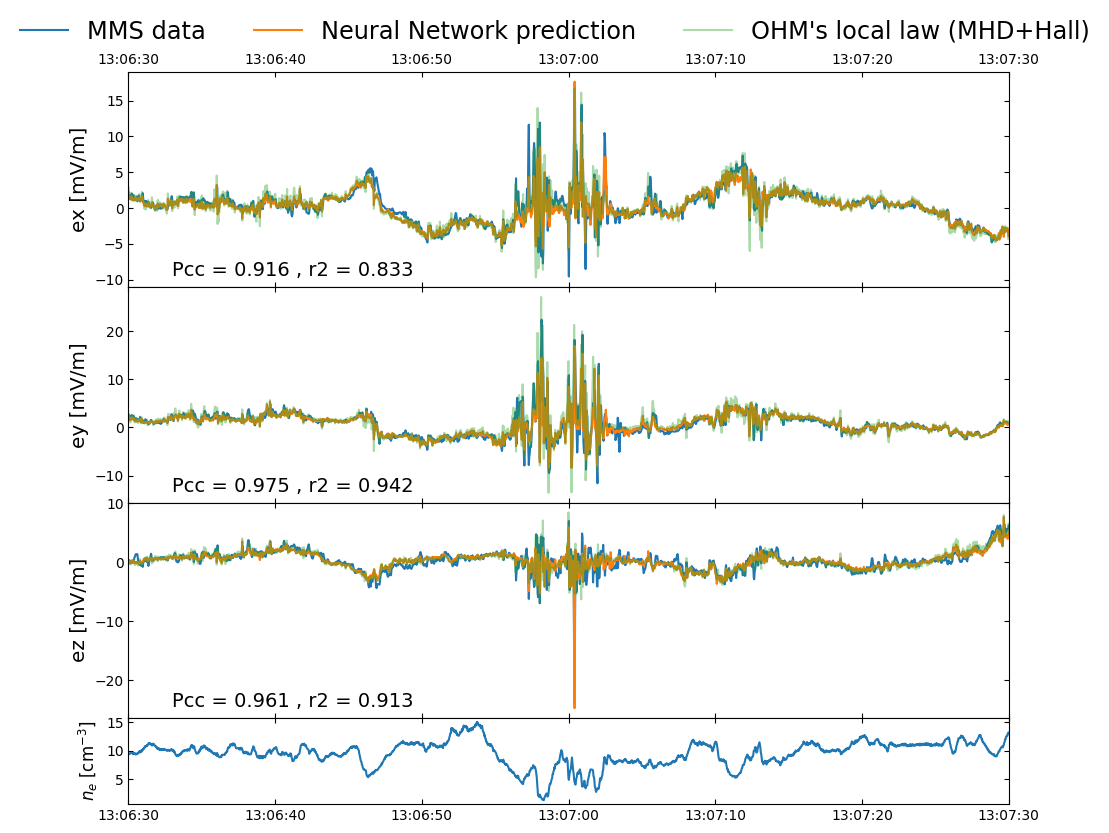

In [44]:
fig, axes = plt.subplots(nrows=4,figsize=(10,8),sharex=True,gridspec_kw={'height_ratios': [3, 3, 3, 1.2]})
for j,col in enumerate(['ex','ey','ez']):
    axes[j].plot(df_test[col],label=f"MMS data")
    axes[j].plot(df_predict[col],label=f"Neural Network prediction")

    axes[j].plot(df_predict.index,df_predict[col+'_mhd'].__array__()+df_predict[col+'_hall'].__array__(),label=f"OHM's local law (MHD+Hall)",alpha=0.4)
    text = str('Pcc = {:.3}'.format(pcc_LMN_filtered[j])) + str(' , r2 = {:.3}'.format(r2_LMN_filtered[j]))
    axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)

    #axes[j].legend(loc=2)
    axes[j].set_xlim(datetime(2015,10,16,13,6,30), datetime(2015,10,16,13,7,30))
    if j==0:
        axes[j].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=True)
        axes[j].xaxis.set_label_position('top')
    if j==1:
        axes[j].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=False)   
    if j==2:
        axes[j].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=False, labeltop=False)
    
    axes[j].set_ylabel(f'{col} [mV/m]',fontsize='x-large')
    axes[j].tick_params(axis="y",which='both',direction='in', left=True, right=True, labelleft=True)
    #axes[j].yaxis.set_label_position("right")

axes[3].plot(df_test.index,df_test['e_density'])

axes[3].tick_params(axis="x",which='both',direction='in', bottom=True, top=True, labelbottom=True, labeltop=False)
axes[3].tick_params(axis="y",which='both',direction='in', left=True, right=True, labelleft=True, labelright=False)

axes[3].set_ylabel('$n_e$ [cm$^{-3}$]',fontsize='large')
    
fig.legend(axes[2].get_legend_handles_labels()[1],frameon=False,loc=9,ncols=3, fontsize='xx-large',bbox_to_anchor=(0.5, 1.05))
#fig.suptitle(f"Chen, L.-J., et al. (2016), Electron energization and mixing observed by MMS \n in the vicinity of an electron diffusion region during magnetopause reconnection \n {sat}")
fig.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0)

plt.savefig('./fig/burch.svg',dpi=200,bbox_inches='tight') #For slides
plt.savefig('./fig/burch.pdf',dpi=200,bbox_inches='tight') #For paper

## Stawarz et al. (2021) - Comparative Analysis of the Various Generalized Ohm's Law Terms in Magnetosheath Turbulence as Observed by Magnetospheric Multiscale

In [200]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = config['data']['t1']
        t2 = config['data']['t2']
        sat = config['data']['sat']
        density_threshold = config['data']['density_threshold']
        name = "rep_no_thresh_XL"
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

        Path(f"{saved_models_path}/{name}").mkdir(parents=True, exist_ok=True)
        with open(f"{saved_models_path}/{name}/model_config.toml",'w') as fsave:
            toml.dump(config,fsave)

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda'

print(f"Using {device} device")
print(f"OHM={OHM}")
print(f"density_threshold={density_threshold}")
file = h5py.File(f'{data_path}','r')
bursts = list(file[f"{sat}"].keys())
file.close()
bursts = pd.DataFrame([datetime.strptime(burst, f'%Y_%m_%dT%H_%M_%S') for burst in bursts])
dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)

train_data, val_data, test_data = random_split(dataset, [0.8, 0.1, 0.1],generator=torch.Generator().manual_seed(seed))

batch_size = int(2**(np.round(np.log2(0.25*len(train_data)/100))))
print(f"Batch size of ~0.25% of data (rounded to closest power of 2) : {batch_size}")
scale = Standard_Scaler(train_data)
#torch.save(scale,f'{saved_models_path}/{name}/scale.keras')
#torch.load()
X_train, y_train = scale.transform(dataset=train_data)
X_val  , y_val   = scale.transform(dataset=val_data)
X_test , y_test  = scale.transform(dataset=test_data)

scale.to(device)
X_train, y_train = X_train.to(device) , y_train.to(device)

print(device)
df = dataset.to_dataframe()
df_train, df_val, df_test = train_data.dataset.to_dataframe(), val_data.dataset.to_dataframe(), test_data.dataset.to_dataframe()
def first_dnn(input_size,output_size,scale,device):
    model = keras.Sequential([
        layers.Dense(input_size, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(output_size)
    ])
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(0.0001),metrics=[
                    MaxError(scaler=scale,device=device),
                    MSE(scaler=scale,device=device),
                    keras.metrics.R2Score(
                    class_aggregation=None, num_regressors=0, name="r2_score", dtype=None),
                    PCC()])

    return model
model = first_dnn(np.shape(X_train)[1]-3,3,scale,device)
test_predict = model.predict(X_test,batch_size) 
#Didn't found a way to load model with sizes correctly initialized, so I run a quick evaluate to fixe the output, load the weights then reload it.
model.load_weights(f'{saved_models_path}/{name}/_weights.best.keras')
test_predict = model.predict(X_test,batch_size)
model.summary()


Using cuda device
OHM=True
density_threshold=0
Batch size of ~0.25% of data (rounded to closest power of 2) : 32768
cuda
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
  4/358 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step 

/home/esevegnes/miniconda3/envs/astorch/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (32768, 13)            │           221 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32768, 1024)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32768, 1024)          │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32768, 1024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32768, 3)             │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,832 (8.08 MB)

 Trainable params: 2,116,832 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [201]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = './data_stawarz_burst.hdf5'
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']
        
df_stawarz_burst = pd.DataFrame()
n_I = []
t_sampling = 0.00015 #s
for j,(t1,t2) in enumerate([(datetime(2016,9,28,16,50,14),datetime(2016,9,28,17,3,31)),(datetime(2016,12,9,9,1,0),datetime(2016,12,9,9,7,0)),(datetime(2017,1,28,9,5,0),datetime(2017,1,28,9,12,0))]):
        interval = ['I1','I2','I3'][j]
        for sat in ['mms1','mms2','mms3','mms4']:
                dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
                df_test = dataset.to_dataframe()
                test_data = torch.utils.data.Subset(dataset,np.arange(len(dataset)))
                #test_data ,_ = random_split(dataset, [1,0])

                #print(test_data.dataset.values)

                scale.to('cpu')
                X_test, y_test = scale.transform(test_data)
                scale.to(device)
                X_test, y_test = X_test.to(device) , y_test.to(device)

                test_burch = torch.Tensor(model.predict(X_test,batch_size))

                #model.summary()

                metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True,verbose=0)
                #print(metrics)

                scale.to('cpu')
                X_test = X_test.to('cpu')

                _, predict = scale.untransform(X_test,test_burch)
                # test 
                df_predict = df_test.copy()
                df_predict[['ex','ey','ez']] = predict
                df_stawarz_burst_I = pd.DataFrame()

                # using matlab default parameters to fit Stawarz parameters
                nsc = np.floor(len(df_test)/3)
                nov = np.floor(nsc/2);
                nff = max(256,2**(np.ceil(np.log2(nsc))))
                
                df_stawarz_burst_I[f'{interval}_{sat}_freq'], df_stawarz_burst_I[f'{interval}_{sat}_fft'] = (welch(df_test[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                                                       fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[0], 
                                                                                                        (welch(df_test[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                                                               fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[1]).sum(axis=1))
                
                _, df_stawarz_burst_I[f'{interval}_{sat}_fft_pred'] = (welch(df_predict[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                          fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[0],
                                                                        (welch(df_predict[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                               fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[1]).sum(axis=1))
                #np.absolute(rfft(np.array(((df_test[['ex','ey','ez']])**2)),n=2*len(df_test[['ex','ey','ez']]),axis=0)).sum(axis=1)# + np.cross(df_predict[['ux','uy','uz']].mean(),df_predict[['bx','by','bz']])/1e3),axis=1)

                df_stawarz_burst = pd.concat([df_stawarz_burst,df_stawarz_burst_I])
                n_I.append(len(df_test))
                #print(n_I[-1])
                #print(len(df_stawarz_I[f'{interval}_{sat}_fft_pred']))
                '''
                fig, axes = plt.subplots(nrows=4,figsize=(9,7),sharex=True,gridspec_kw={'height_ratios': [3, 3, 3, 1.2]})
                for j,col in enumerate(['ex','ey','ez']):
                        axes[j].plot(df_test.index,df_test[col],label=f"measured {col}")
                        axes[j].plot(df_predict.index,df_predict[col],label=f"predicted {col}")
                        lims = axes[j].get_ylim()
                        axes[j].plot(df_predict.index,df_predict[col+"_mhd"]+df_predict[col+'_hall'],label=f"OHM {col}",alpha=0.3)
                        text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][j]))
                        axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
                        axes[j].set_ylim(lims)
                        axes[j].legend(loc=4)

                        axes[3].plot(df_test.index,df_test['e_density'],label='electronic density')
                        axes[3].legend()
                        #axes[3].set_yscale('log')
                        fig.suptitle(f"Stawarz et al. (2021) - Comparative Analysis of the Various Generalized Ohm's Law Terms \n in Magnetosheath Turbulence as Observed by Magnetospheric Multiscale - {interval}/{sat}")
                        fig.tight_layout()
                        plt.subplots_adjust(hspace=0)'''
                        
df_stawarz_burst = pd.concat([df_stawarz_burst[col].dropna()[:1048577] for col in df_stawarz_burst.columns],axis=1)
df_stawarz_burst_2 = pd.DataFrame()
for interval in ['I1','I2','I3']:
    df_stawarz_burst_2[f'{interval}_freq'] = df_stawarz_burst[[f'{interval}_{sat}_freq' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)
    df_stawarz_burst_2[f'{interval}_fft'] = df_stawarz_burst[[f'{interval}_{sat}_fft' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)
    df_stawarz_burst_2[f'{interval}_fft_pred'] = df_stawarz_burst[[f'{interval}_{sat}_fft_pred' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)

185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [202]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2016,9,28,16,50,0)
        t2 = datetime(2016,9,28,17,4,0)
        sat = 'mms1'
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = './data_stawarz.hdf5'
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']
        
df_stawarz= pd.DataFrame()
n_I = []
t_sampling = 0.03 #s
for j,(t1,t2) in enumerate([(datetime(2016,9,28,16,50,14),datetime(2016,9,28,17,3,31)),(datetime(2016,12,9,9,1,0),datetime(2016,12,9,9,7,0)),(datetime(2017,1,28,9,5,0),datetime(2017,1,28,9,12,0))]):
        interval = ['I1','I2','I3'][j]
        for sat in ['mms1','mms2','mms3','mms4']:
                dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM)
                df_test = dataset.to_dataframe()
                test_data = torch.utils.data.Subset(dataset,np.arange(len(dataset)))
                #test_data ,_ = random_split(dataset, [1,0])

                #print(test_data.dataset.values)

                scale.to('cpu')
                X_test, y_test = scale.transform(test_data)
                scale.to(device)
                X_test, y_test = X_test.to(device) , y_test.to(device)

                test_burch = torch.Tensor(model.predict(X_test,batch_size))

                #model.summary()

                metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True,verbose=0)
                #print(metrics)

                scale.to('cpu')
                X_test = X_test.to('cpu')

                _, predict = scale.untransform(X_test,test_burch)
                # test 
                df_predict = df_test.copy()
                df_predict[['ex','ey','ez']] = predict
                df_stawarz_I = pd.DataFrame()

                # using matlab default parameters to fit Stawarz parameters
                nsc = np.floor(len(df_test)/3) #nperseg
                nov = np.floor(nsc/2)
                nff = max(256,2**(np.ceil(np.log2(nsc))))
                
                df_stawarz_I[f'{interval}_{sat}_freq'], df_stawarz_I[f'{interval}_{sat}_fft'] = (welch(df_test[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                                                       fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[0], 
                                                                                                        (welch(df_test[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                                                               fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[1]).sum(axis=1))
                
                #np.absolute(rfft(np.array(((df_test[['ex','ey','ez']])**2)),n=2*len(df_test[['ex','ey','ez']]),axis=0)).sum(axis=1)
                #+ np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3
                #np.linalg.norm(np.fft.rfft((df_test[['ex','ey','ez']]+ np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3),axis=0),axis=1)
                #df_stawarz_I[f'{interval}_{sat}_fft_pred'] = np.absolute(np.fft.rfft((df_predict[['ex','ey','ez']]+ np.cross(df_predict[['ux','uy','uz']].mean(),df_predict[['bx','by','bz']])/1e3)**2,axis=0)).sum(axis=1)
                freq, df_stawarz_I[f'{interval}_{sat}_fft_pred'] = (welch(df_predict[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                          fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[0],
                                                                        (welch(df_predict[['ex','ey','ez']] + 1*np.cross(df_test[['ux','uy','uz']].mean(),df_test[['bx','by','bz']])/1e3,
                                                                               fs=1/t_sampling,nperseg=nsc,noverlap=nov,nfft=nff,detrend=False,axis=0)[1]).sum(axis=1))
                #np.absolute(rfft(np.array(((df_test[['ex','ey','ez']])**2)),n=2*len(df_test[['ex','ey','ez']]),axis=0)).sum(axis=1)# + np.cross(df_predict[['ux','uy','uz']].mean(),df_predict[['bx','by','bz']])/1e3),axis=1)

                df_stawarz = pd.concat([df_stawarz,df_stawarz_I])
                n_I.append(len(df_test))
                #print(n_I[-1])
                #print(len(df_stawarz_I[f'{interval}_{sat}_fft_pred']))
                '''
                fig, axes = plt.subplots(nrows=4,figsize=(9,7),sharex=True,gridspec_kw={'height_ratios': [3, 3, 3, 1.2]})
                for j,col in enumerate(['ex','ey','ez']):
                        axes[j].plot(df_test.index,df_test[col],label=f"measured {col}")
                        axes[j].plot(df_predict.index,df_predict[col],label=f"predicted {col}")
                        lims = axes[j].get_ylim()
                        axes[j].plot(df_predict.index,df_predict[col+"_mhd"]+df_predict[col+'_hall'],label=f"OHM {col}",alpha=0.3)
                        text = str('Pcc = {:.3}'.format(metrics['PCC'][j])) + str(' , r2 = {:.3}'.format(metrics['r2_score'][j]))
                        axes[j].text(0.05, 0.05, text, fontsize=14, transform=axes[j].transAxes)
                        axes[j].set_ylim(lims)
                        axes[j].legend(loc=4)

                        axes[3].plot(df_test.index,df_test['e_density'],label='electronic density')
                        axes[3].legend()
                        #axes[3].set_yscale('log')
                        fig.suptitle(f"Stawarz et al. (2021) - Comparative Analysis of the Various Generalized Ohm's Law Terms \n in Magnetosheath Turbulence as Observed by Magnetospheric Multiscale - {interval}/{sat}")
                        fig.tight_layout()
                        plt.subplots_adjust(hspace=0)'''

df_stawarz = pd.concat([df_stawarz[col].dropna()[:26361] for col in df_stawarz.columns],axis=1)
df_stawarz_2 = pd.DataFrame()
for interval in ['I1','I2','I3']:
    df_stawarz_2[f'{interval}_freq'] = df_stawarz[[f'{interval}_{sat}_freq' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)
    df_stawarz_2[f'{interval}_fft'] = df_stawarz[[f'{interval}_{sat}_fft' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)
    df_stawarz_2[f'{interval}_fft_pred'] = df_stawarz[[f'{interval}_{sat}_fft_pred' for sat in ['mms1','mms2','mms3','mms4']]].mean(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


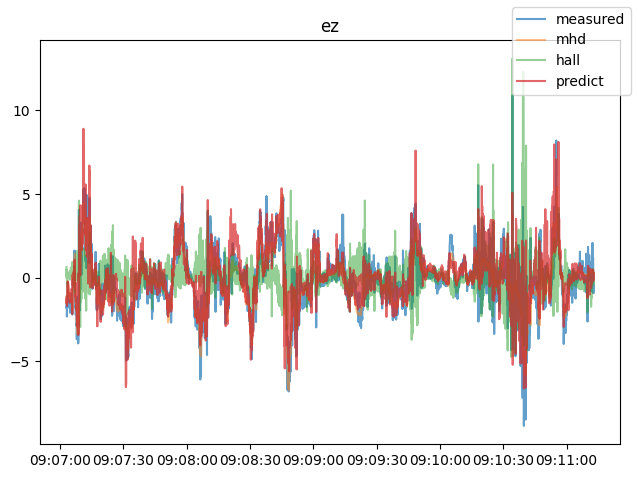

In [236]:
fig, ax = plt.subplots()
col="ez"
ax.plot(df_test[col],label='measured',alpha=0.7)
ax.plot(df_test[col+"_mhd"],label='mhd',alpha=0.5)
ax.plot(df_test[col+"_hall"],label='hall',alpha=0.5)
ax.plot(df_predict[col],label='predict',alpha=0.7)
ax.set_title(col)
fig.legend()
plt.tight_layout()

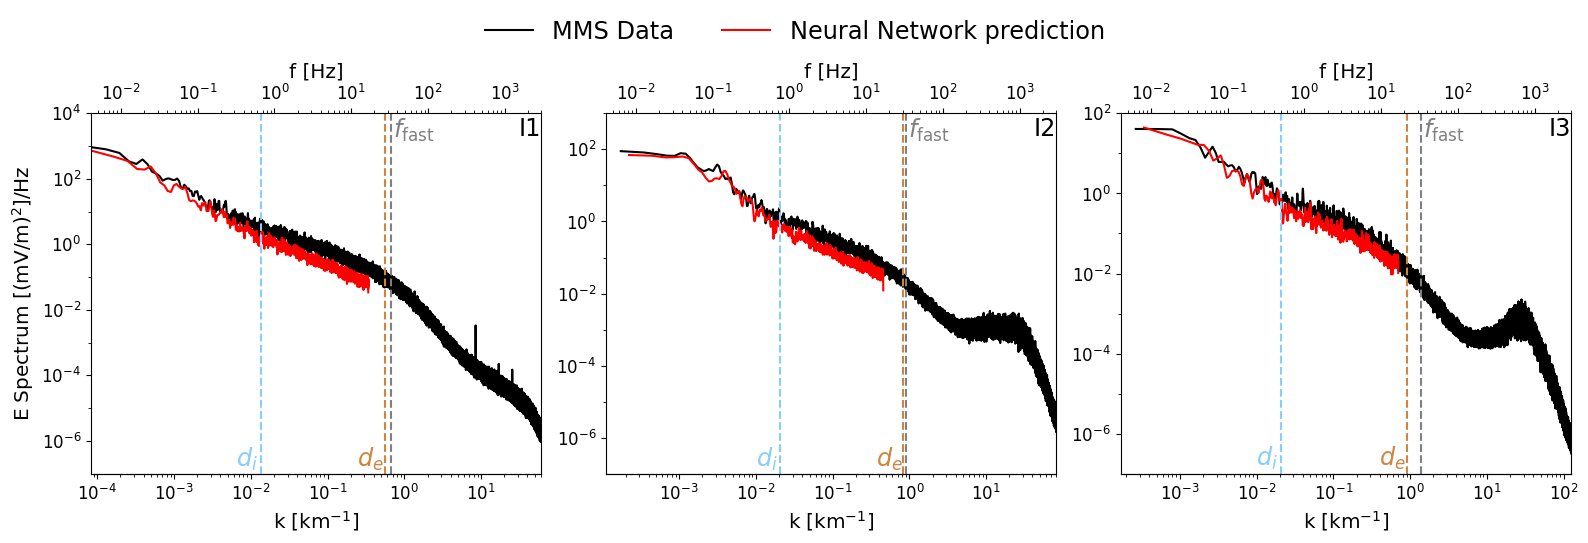

In [203]:
#freq = np.fft.fftfreq(len(df_stawarz_2),t_sampling)#np.arange(len(df_stawarz_2))/(t_sampling*len(df_stawarz_2))
fig, axes = plt.subplots(ncols=3,figsize=(16,5),sharex=True)
for j,ax in enumerate(axes):
    interval = ['I1','I2','I3'][j]
    
    # Burst mode
    ax.plot(df_stawarz_burst_2[f'{interval}_freq'].dropna()[1:],df_stawarz_burst_2[f'{interval}_fft'].dropna()[1:],color='k',label='MMS Data')
    #ax.plot(df_stawarz_burst_2[f'{interval}_freq'].dropna()[1:],df_stawarz_burst_2[f'{interval}_fft_pred'].dropna()[1:],color='orange')

    # Fast mode
    #ax.plot(df_stawarz_2[f'{interval}_freq'].dropna()[1:],df_stawarz_2[f'{interval}_fft'].dropna()[1:],linestyle='dashed',color='brown',alpha=0.8)
    ax.plot(df_stawarz_2[f'{interval}_freq'].dropna()[1:],df_stawarz_2[f'{interval}_fft_pred'].dropna()[1:],linestyle='solid',color='red',label='Neural Network prediction')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yticks([1e-6,1e-4,1e-2,1e0,1e2,1e4])
    ax.set_yticks([1e-5,1e-3,1e-1,1e1,1e3],labels=['','','','',''],minor=True)
    ax.set_xticks([1e-2,1e-1,1e0,1e1,1e2,1e3])
    
    ax.set_xlabel('f [Hz]',fontsize='x-large')
    ax.xaxis.set_label_position('top')
    if j==0:
        f0 = df_stawarz_2[f'I1_freq'].dropna()[1]
        ax.tick_params(axis="x",which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
        ax.set_ylabel('E Spectrum [(mV/m)$^2$]/Hz',fontsize='x-large')
    
        secax_0 = ax.secondary_xaxis('bottom', functions=(lambda x: x*(310/(2*np.pi))**(-1),lambda x:x*(310/(2*np.pi))))
        secax_0.set_xlabel('k [km$^{-1}$]',fontsize='x-large')

    ax.text([310/(2*np.pi*1.8),230/(2*np.pi*1.2),150/(2*np.pi*1.1)][j]-1,1.6e-7,'$d_e$',color='peru',fontsize='xx-large',ha='right')
    ax.text([310/(2*np.pi*75),230/(2*np.pi*49),150/(2*np.pi*48)][j]-0.05,1.6e-7,'$d_i$',color='lightskyblue',fontsize='xx-large',ha='right')
    ax.text(1/0.03 + 2,0.8*[1e4,1e3,1e2][j],'$f_{\\mathrm{fast}}$',color='gray',fontsize='xx-large',ha='left',va='top')
    if j==1:
        ax.tick_params(axis="x",which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
        secax_1 = ax.secondary_xaxis('bottom', functions=(lambda x: x*(230/(2*np.pi))**(-1),lambda x:x*(230/(2*np.pi))))
        secax_1.set_xlabel('k [km$^{-1}$]',fontsize='x-large')
    if j==2:
        ax.tick_params(axis="x",which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
        secax_2 = ax.secondary_xaxis('bottom', functions=(lambda x: x*(150/(2*np.pi))**(-1),lambda x:x*(150/(2*np.pi))))
        secax_2.set_xlabel('k [km$^{-1}$]',fontsize='x-large')

    ax.text(1,0.99,interval,ha='right',va='top',fontsize='xx-large',transform=ax.transAxes)
    
    ax.set_xlim(left=f0,right=3e3)
    ax.set_ylim(1e-7,[1e4,1e3,1e2][j])

    ax.axvline([310/(2*np.pi*1.8),230/(2*np.pi*1.2),150/(2*np.pi*1.1)][j],linestyle='dashed',color='peru')
    ax.axvline([310/(2*np.pi*75),230/(2*np.pi*49),150/(2*np.pi*48)][j],linestyle='dashed',color='lightskyblue')
    ax.axvline(1/0.03,linestyle='dashed',color='gray')
    ax.tick_params(labelsize='large')


    #End loop
secax_0.tick_params(labelsize='large')
secax_1.tick_params(labelsize='large')
secax_2.tick_params(labelsize='large')

fig.legend(axes[0].get_legend_handles_labels()[1],frameon=False,loc=9,ncols=2, fontsize='xx-large',bbox_to_anchor=(0.5, 1.1))
fig.tight_layout()

plt.savefig('./fig/stawarz_R.svg',dpi=200,bbox_inches='tight')
plt.savefig('./fig/stawarz_R.pdf',dpi=200,bbox_inches='tight')
#plt.subplots_adjust(wspace=0)

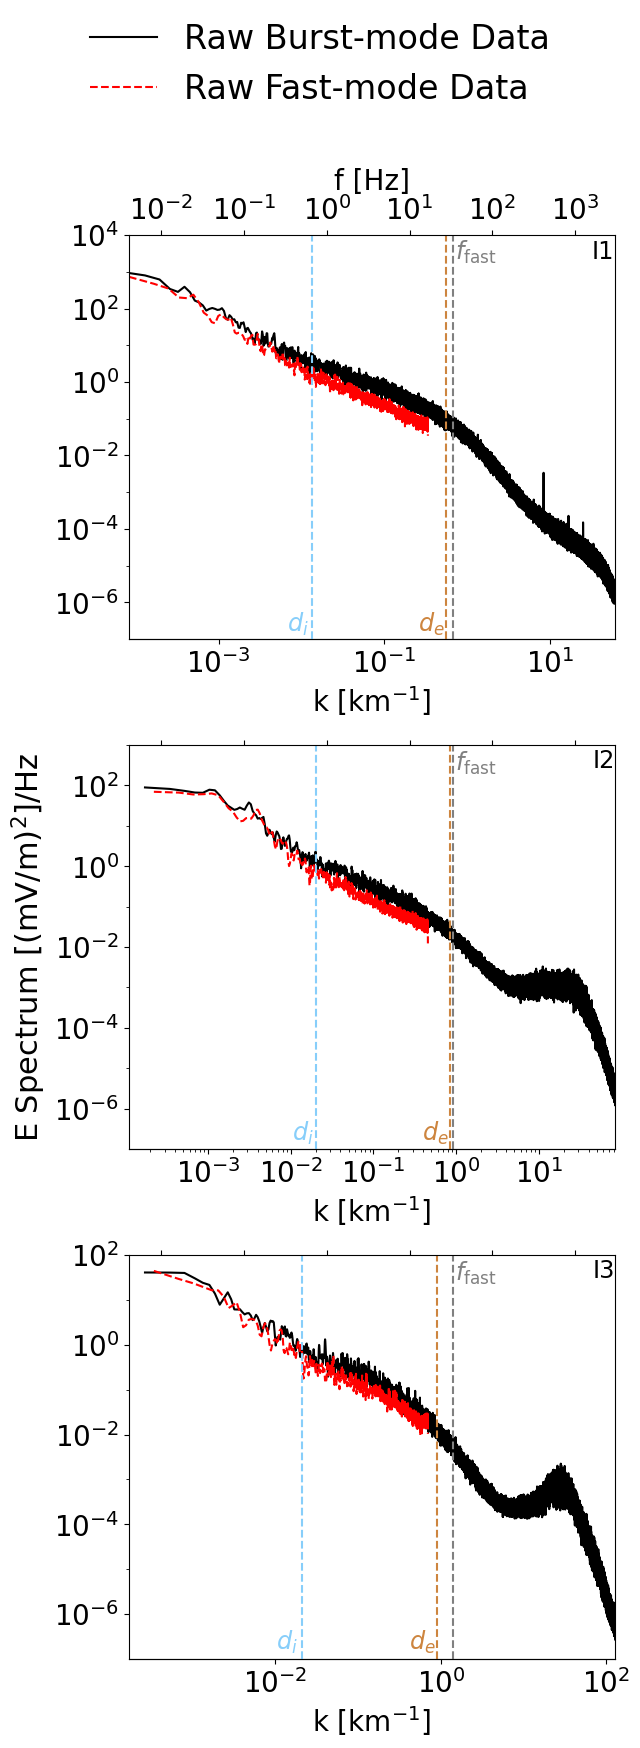

In [216]:
#freq = np.fft.fftfreq(len(df_stawarz_2),t_sampling)#np.arange(len(df_stawarz_2))/(t_sampling*len(df_stawarz_2))
fig, axes = plt.subplots(nrows=3,figsize=(6.5,16),sharex=True)
for j,ax in enumerate(axes):
    interval = ['I1','I2','I3'][j]
    
    # Burst mode
    ax.plot(df_stawarz_burst_2[f'{interval}_freq'].dropna()[1:],df_stawarz_burst_2[f'{interval}_fft'].dropna()[1:],color='k',label="Raw Burst-mode Data")
    #ax.plot(df_stawarz_burst_2[f'{interval}_freq'].dropna()[1:],df_stawarz_burst_2[f'{interval}_fft_pred'].dropna()[1:],color='orange')

    # Fast mode
    #ax.plot(df_stawarz_2[f'{interval}_freq'].dropna()[1:],df_stawarz_2[f'{interval}_fft'].dropna()[1:],linestyle='dashed',color='brown',alpha=0.8)
    ax.plot(df_stawarz_2[f'{interval}_freq'].dropna()[1:],df_stawarz_2[f'{interval}_fft_pred'].dropna()[1:],linestyle='dashed',color='red',label="Raw Fast-mode Data",alpha=1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yticks([1e-6,1e-4,1e-2,1e0,1e2,1e4])
    ax.set_yticks([1e-5,1e-3,1e-1,1e1,1e3],labels=['','','','',''],minor=True)
    ax.set_xticks([1e-2,1e-1,1e0,1e1,1e2,1e3])
    

    if j==0:
        ax.set_xlabel('f [Hz]',fontsize=20)
        ax.xaxis.set_label_position('top')
        f0 = df_stawarz_2[f'I1_freq'].dropna()[1]
        ax.tick_params(axis="x",which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
        
    
        secax_0 = ax.secondary_xaxis('bottom', functions=(lambda x: x*(310/(2*np.pi))**(-1),lambda x:x*(310/(2*np.pi))))
        secax_0.set_xlabel('k [km$^{-1}$]',fontsize=20)

    ax.text([310/(2*np.pi*1.8),230/(2*np.pi*1.2),150/(2*np.pi*1.1)][j]-1,1.6e-7,'$d_e$',color='peru',fontsize='xx-large',ha='right')
    ax.text([310/(2*np.pi*75),230/(2*np.pi*49),150/(2*np.pi*48)][j]-0.05,1.6e-7,'$d_i$',color='lightskyblue',fontsize='xx-large',ha='right')
    ax.text(1/0.03 + 2,0.8*[1e4,1e3,1e2][j],'$f_{\\mathrm{fast}}$',color='gray',fontsize='xx-large',ha='left',va='top')
    if j==1:
        ax.tick_params(axis="x",which='both', bottom=False, top=True, labelbottom=False, labeltop=False)
        secax_1 = ax.secondary_xaxis('bottom', functions=(lambda x: x*(230/(2*np.pi))**(-1),lambda x:x*(230/(2*np.pi))))
        secax_1.set_xlabel('k [km$^{-1}$]',fontsize=20)
        ax.set_ylabel('E Spectrum [(mV/m)$^2$]/Hz',fontsize=22)
    if j==2:
        ax.tick_params(axis="x",which='both', bottom=False, top=True, labelbottom=False, labeltop=False)
        secax_2 = ax.secondary_xaxis('bottom', functions=(lambda x: x*(150/(2*np.pi))**(-1),lambda x:x*(150/(2*np.pi))))
        secax_2.set_xlabel('k [km$^{-1}$]',fontsize=20)

    ax.text(1,0.99,interval,ha='right',va='top',fontsize='xx-large',transform=ax.transAxes)
    
    ax.set_xlim(left=f0,right=3e3)
    ax.set_ylim(1e-7,[1e4,1e3,1e2][j])

    ax.axvline([310/(2*np.pi*1.8),230/(2*np.pi*1.2),150/(2*np.pi*1.1)][j],linestyle='dashed',color='peru')
    ax.axvline([310/(2*np.pi*75),230/(2*np.pi*49),150/(2*np.pi*48)][j],linestyle='dashed',color='lightskyblue')
    ax.axvline(1/0.03,linestyle='dashed',color='gray')

    ax.tick_params(labelsize=20)

secax_0.tick_params(labelsize=20)
secax_1.tick_params(labelsize=20)
secax_2.tick_params(labelsize=20)

fig.tight_layout()
fig.legend(axes[0].get_legend_handles_labels()[1],frameon=False,loc=9, fontsize=24,bbox_to_anchor=(0.5, 1.1))

#plt.savefig('./fig/stawarz_C.svg',dpi=200,bbox_inches='tight')
plt.savefig('./fig/stawarz_C.pdf',dpi=200,bbox_inches='tight')
#plt.subplots_adjust(wspace=0)

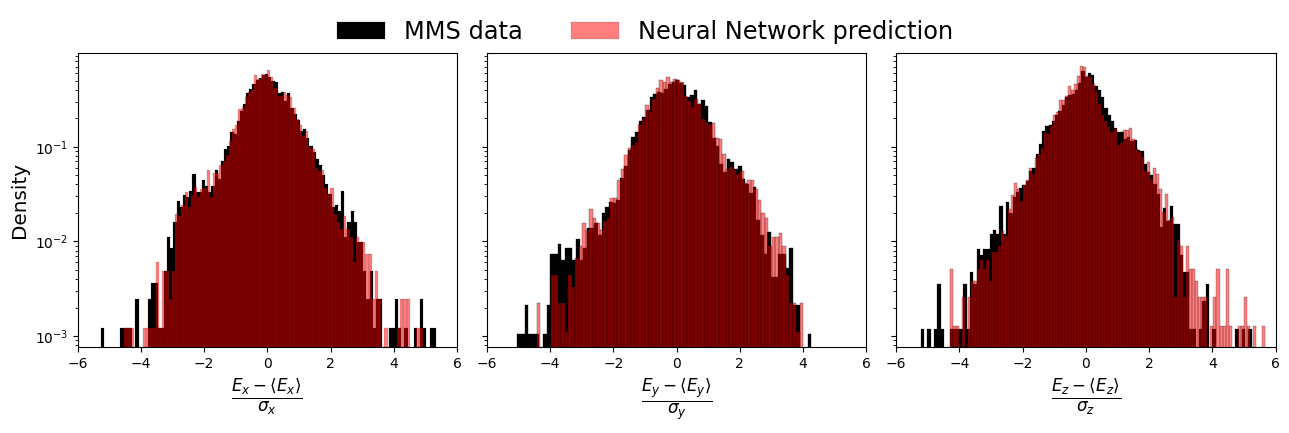

In [205]:
## test 1

output_targets = ['ex','ey','ez']

fig, ax = plt.subplots(ncols=len(output_targets), figsize=(13,4),sharey=True)
plt.subplots_adjust(hspace=0.2)

for j,col in enumerate(output_targets):
        sns.histplot((df_test[col]-df_test[col].mean())/df_test[col].std(),ax=ax[j],stat='density',color='black',alpha=1,label='MMS data')
        sns.histplot((df_predict[col]-df_predict[col].mean())/df_predict[col].std(),ax=ax[j],stat='density',color='red',alpha=0.5,label='Neural Network prediction')
        ax[j].set_xlabel("$\\frac{E_{"+f"{col[-1]}" +"}- \\langle E_{"+f"{col[-1]}"+"}\\rangle}{\\sigma_{"f"{col[-1]}"+"}}$",size="xx-large")
        ax[j].set_ylabel('Density',size='x-large')
        ax[j].set_xticks(np.arange(-10,11,2))

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_xlim(-6,6)
ax[1].set_xlim(-6,6)
ax[2].set_xlim(-6,6)

fig.legend(ax[0].get_legend_handles_labels()[1],frameon=False,loc=9,ncols=2, fontsize='xx-large',bbox_to_anchor=(0.5, 1.1))

fig.tight_layout()

plt.savefig('./fig/PDF.svg',dpi=200,bbox_inches='tight')
plt.savefig('./fig/PDF.pdf',dpi=200,bbox_inches='tight')

## Transfer Learning

In [51]:
with open('./model_config.toml','r') as f:
        config = toml.load(f)
        seed = config['stat']['seed']
        t1 = datetime(2015,10,16,12,0,0)
        t2 = datetime(2015,10,16,14,0,0)
        density_threshold = 0
        name = config['model']['name']
        f_train, f_valid, f_test = config['model']['f_train'], config['model']['f_valid'], config['model']['f_test']
        shuffle = config['model']['shuffle']
        OHM = config['model']['OHM']
        epochs = config['model']['epochs']
        patience = config['model']['patience']
        data_path = config['paths']['data']
        saved_models_path = config['paths']['saved_models']
        log_path = config['paths']['logs']

sat = 'mms1'
dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM,XYZ=True)
df_test = dataset.to_dataframe()
test_data = torch.utils.data.Subset(dataset,np.arange(len(dataset)))

scale.to('cpu')
X_test, y_test = scale.transform(test_data)
scale.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

test_burch = torch.Tensor(model.predict(X_test,batch_size))

#model.summary()

metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True,verbose=0)
#print(metrics)

scale.to('cpu')
X_test = X_test.to('cpu')

_, predict = scale.untransform(X_test,test_burch)

df_mms1 = df_test.copy()
df_mms1[['x','y','z']] = dataset.xyz
df_mms1[['ex_pred','ey_pred','ez_pred']] = predict

df_err = pd.DataFrame()

for sat in ['mms2','mms3','mms4']:
        dataset = MMS_Dataset(sat,data_path,t1,t2,density_threshold,OHM=OHM,XYZ=True)
        df_test = dataset.to_dataframe()
        test_data = torch.utils.data.Subset(dataset,np.arange(len(dataset)))

        scale.to('cpu')
        X_test, y_test = scale.transform(test_data)
        scale.to(device)
        X_test, y_test = X_test.to(device) , y_test.to(device)

        test_burch = torch.Tensor(model.predict(X_test,batch_size))

        #model.summary()

        metrics = model.evaluate(X_test, y_test,batch_size,return_dict=True,verbose=0)
        #print(metrics)

        scale.to('cpu')
        X_test = X_test.to('cpu')

        _, predict = scale.untransform(X_test,test_burch)
        
        df_mms = df_test.copy()
        df_mms[['x','y','z']] = dataset.xyz
        df_mms[['ex_pred','ey_pred','ez_pred']] = predict
        df_mms = df_mms[:len(df_mms1)].dropna()
        df_mms.index = df_mms1.index[:len(df_mms)]

        df_err_loc = pd.DataFrame()
        df_err_loc[[f"{sat}_dX", f"{sat}_dY", f"{sat}_dZ"]] = df_mms[['x','y','z']] - df_mms1[['x','y','z']][:len(df_mms)]
        df_err_loc[[f"{sat}_dEX", f"{sat}_dEY", f"{sat}_dEZ"]] = df_mms[['ex','ey','ez']].__array__() - df_mms[['ex_pred','ey_pred','ez_pred']].__array__()[:len(df_mms)]

        df_err = pd.concat([df_err,df_err_loc],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [52]:
df_err[[f"{sat}_dR" for sat in ['mms2','mms3','mms4']]] = pd.concat([np.sqrt((df_err[[f"{sat}_dX", f"{sat}_dY", f"{sat}_dZ"]]**2).sum(axis=1)) for sat in ['mms2','mms3','mms4']],axis=1)
df_err[[f"{sat}_dE" for sat in ['mms2','mms3','mms4']]] = pd.concat([np.sqrt((df_err[[f"{sat}_dEX", f"{sat}_dEY", f"{sat}_dEZ"]]**2).sum(axis=1)) for sat in ['mms2','mms3','mms4']],axis=1)

In [53]:
df_mms1['deltaE'] = np.sqrt(((df_mms1[['ex','ey','ez']].__array__() - df_mms1[['ex_pred','ey_pred','ez_pred']].__array__())**2).sum(axis=1))

<Axes: >

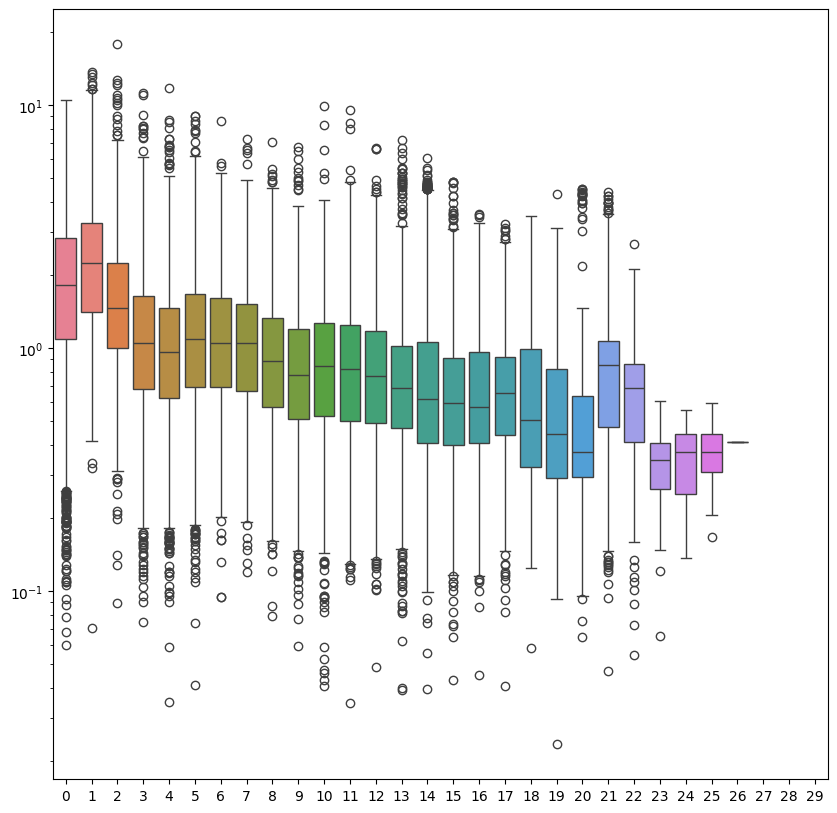

In [54]:
n=31
feature = 'e_density'
bins = np.arange(n)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(pd.concat([df_mms1['deltaE'].iloc[np.where((bins[k] <= df_mms1[feature]) & (df_mms1[feature] < bins[k+1]))] for k in range(n-1)],ignore_index=True,axis=1),ax=ax,log_scale=(False,True))

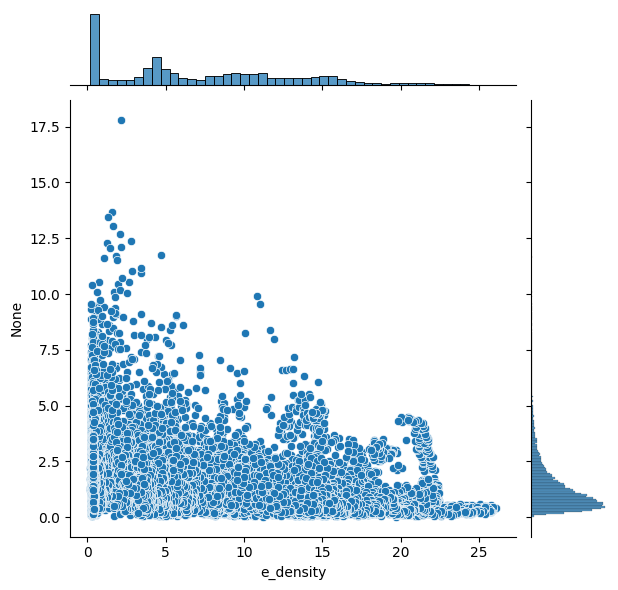

In [55]:
sns.jointplot(x=df_mms1[feature],y=np.sqrt(((df_mms1[['ex','ey','ez']].__array__() - df_mms1[['ex_pred','ey_pred','ez_pred']].__array__())**2).sum(axis=1)),
              )